# Child Health Predictive Analysis
- Authors: Gian Luky S. & Daud M. Azhari
- Date: September 2023

Decrease the prevalence of 3 common diseases in children using machine learning regression models. Apply advanced algorithms to predict disease prevalence and identify key influencing factors. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import datetime

from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, RepeatedKFold
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer, OrdinalEncoder, OneHotEncoder, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score


# models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# EAK
import shap
from sklearn.inspection import permutation_importance

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## 1. Data
1. Viz NA
1. Do EDA
1. Deal with NA
    1. drop MLRDiag
    1. Non NA Response Variable 
    1. Sample 150 from it as test set.
    1. 
    1. Fill Predictor NA using standard method (mean of values)
    1.

In [2]:
df0 = pd.read_excel("/kaggle/input/lomba-23/rasio23.xlsx")
display(df0.head(4))

,ISO Code,Countries and areas,UNICEF Reporting Region,UNICEF Programme Region,World Bank Income Group (2020),Year(s) of data collection,Latest Year,Short Source,Long Source,Indicator,Stratifier,Level,Value,Sample Size Notes,Notes,Source Notes
0,AFG,Afghanistan,South Asia,ROSA,Low income,2010-2011,2011,MICS 2010-2011,Multiple Indicator Cluster Survey 2010-2011,DIARCARE,National,National,18.1,NaN,NaN,NaN
1,AFG,Afghanistan,South Asia,ROSA,Low income,2010-2011,2011,MICS 2010-2011,Multiple Indicator Cluster Survey 2010-2011,DIARCARE,Area,Urban,21.4,NaN,NaN,NaN
2,AFG,Afghanistan,South Asia,ROSA,Low income,2010-2011,2011,MICS 2010-2011,Multiple Indicator Cluster Survey 2010-2011,DIARCARE,Area,Rural,17.6,NaN,NaN,NaN
3,AFG,Afghanistan,South Asia,ROSA,Low income,2010-2011,2011,MICS 2010-2011,Multiple Indicator Cluster Survey 2010-2011,DIARCARE,Sex,Female,18.8,NaN,NaN,NaN


In [3]:
# 132 countries code
df0["ISO Code"].value_counts()
# df0["Level"].value_counts()
# hft, what?

ISO Code
SEN    1369
MWI     852
NGA     799
SLE     786
GHA     753
       ... 
URY       4
TCA       3
MYS       2
CHN       2
QAT       1
Name: count, Length: 132, dtype: int64

In [4]:
df0a = df0.copy()
df0a = df0a.pivot(index=["ISO Code", "Countries and areas",'UNICEF Reporting Region', 
                  "Latest Year", "Level", 'World Bank Income Group (2020)'], columns='Indicator', values='Value')
df0a = df0a.reset_index()
df0a = df0a[df0a.Level.isin(["Urban", "Rural"])]

display(df0a.sample(6))
df0a.info()

df0a.columns[df0a.isna().sum(0)/df0a.shape[0] > 0.5]

# 246 obs
indeks =  df0a[["DIARCARE", "MLRCARE", "PNEUCARE"]].dropna().index
# indeks.sample(150, random_state=0)

df0a.columns = ['ISO', 'Countries', 'Region','Year', 'Area', 'Income', 'DIARCARE',
                'IPTP', 'ITN', 'ITN2', 'ITNOWN', 'ITNPREG', 'MLRACT', 'MLRCARE', 'MLRDIAG', 
                'ORS', 'ORSZINC', 'ORTCF', 'PNEUCARE', 'ZINC']

Indicator,ISO Code,Countries and areas,UNICEF Reporting Region,Latest Year,Level,World Bank Income Group (2020),DIARCARE,IPTP,ITN,ITN2,ITNOWN,ITNPREG,MLRACT,MLRCARE,MLRDIAG,ORS,ORSZINC,ORTCF,PNEUCARE,ZINC
4230,SLB,Solomon Islands,East Asia and Pacific,2015,Urban,Lower middle income,62.3,NaN,56.6,53.1,71.6,41.7,NaN,70.8,56.1,44.9,NaN,58.4,86.8,4.8
4174,SEN,Senegal,West and Central Africa,2017,Rural,Lower middle income,42.1,19.2,63.7,56.6,92.8,67.2,66.7,44.1,16.3,27.6,17.8,44.7,45.5,24.9
3735,PER,Peru,Latin America and Caribbean,2015,Rural,Upper middle income,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.9,NaN,56.6,61.9,NaN
4821,TJK,Tajikistan,Eastern Europe and Central Asia,2017,Rural,Lower middle income,48.2,NaN,NaN,NaN,NaN,NaN,NaN,41.4,11.7,60.6,13.3,61.3,67.9,18.2
162,ARM,Armenia,Eastern Europe and Central Asia,2010,Urban,Upper middle income,41.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.4,30.4,70.0,NaN,NaN
2634,MAR,Morocco,Middle East and North Africa,2004,Rural,Lower middle income,17.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.2,NaN,41.0,25.0,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 990 entries, 1 to 5505
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ISO Code                        990 non-null    object 
 1   Countries and areas             990 non-null    object 
 2   UNICEF Reporting Region         990 non-null    object 
 3   Latest Year                     990 non-null    int64  
 4   Level                           990 non-null    object 
 5   World Bank Income Group (2020)  990 non-null    object 
 6   DIARCARE                        693 non-null    float64
 7   IPTP                            274 non-null    float64
 8   ITN                             482 non-null    float64
 9   ITN2                            200 non-null    float64
 10  ITNOWN                          437 non-null    float64
 11  ITNPREG                         329 non-null    float64
 12  MLRACT                          242 non-

In [5]:
df0a.isna().sum(0)/df0a.shape[0]

ISO          0.000000
Countries    0.000000
Region       0.000000
Year         0.000000
Area         0.000000
Income       0.000000
DIARCARE     0.300000
IPTP         0.723232
ITN          0.513131
ITN2         0.797980
ITNOWN       0.558586
ITNPREG      0.667677
MLRACT       0.755556
MLRCARE      0.633333
MLRDIAG      0.719192
ORS          0.235354
ORSZINC      0.693939
ORTCF        0.311111
PNEUCARE     0.289899
ZINC         0.658586
dtype: float64

### First EDA
1. Handling Missing Value

ISO          990
Countries    990
Region       990
Year         990
Area         990
Income       990
ORS          757
PNEUCARE     703
DIARCARE     693
ORTCF        682
ITN          482
ITNOWN       437
MLRCARE      363
ZINC         338
ITNPREG      329
ORSZINC      303
MLRDIAG      278
IPTP         274
MLRACT       242
ITN2         200
dtype: int64

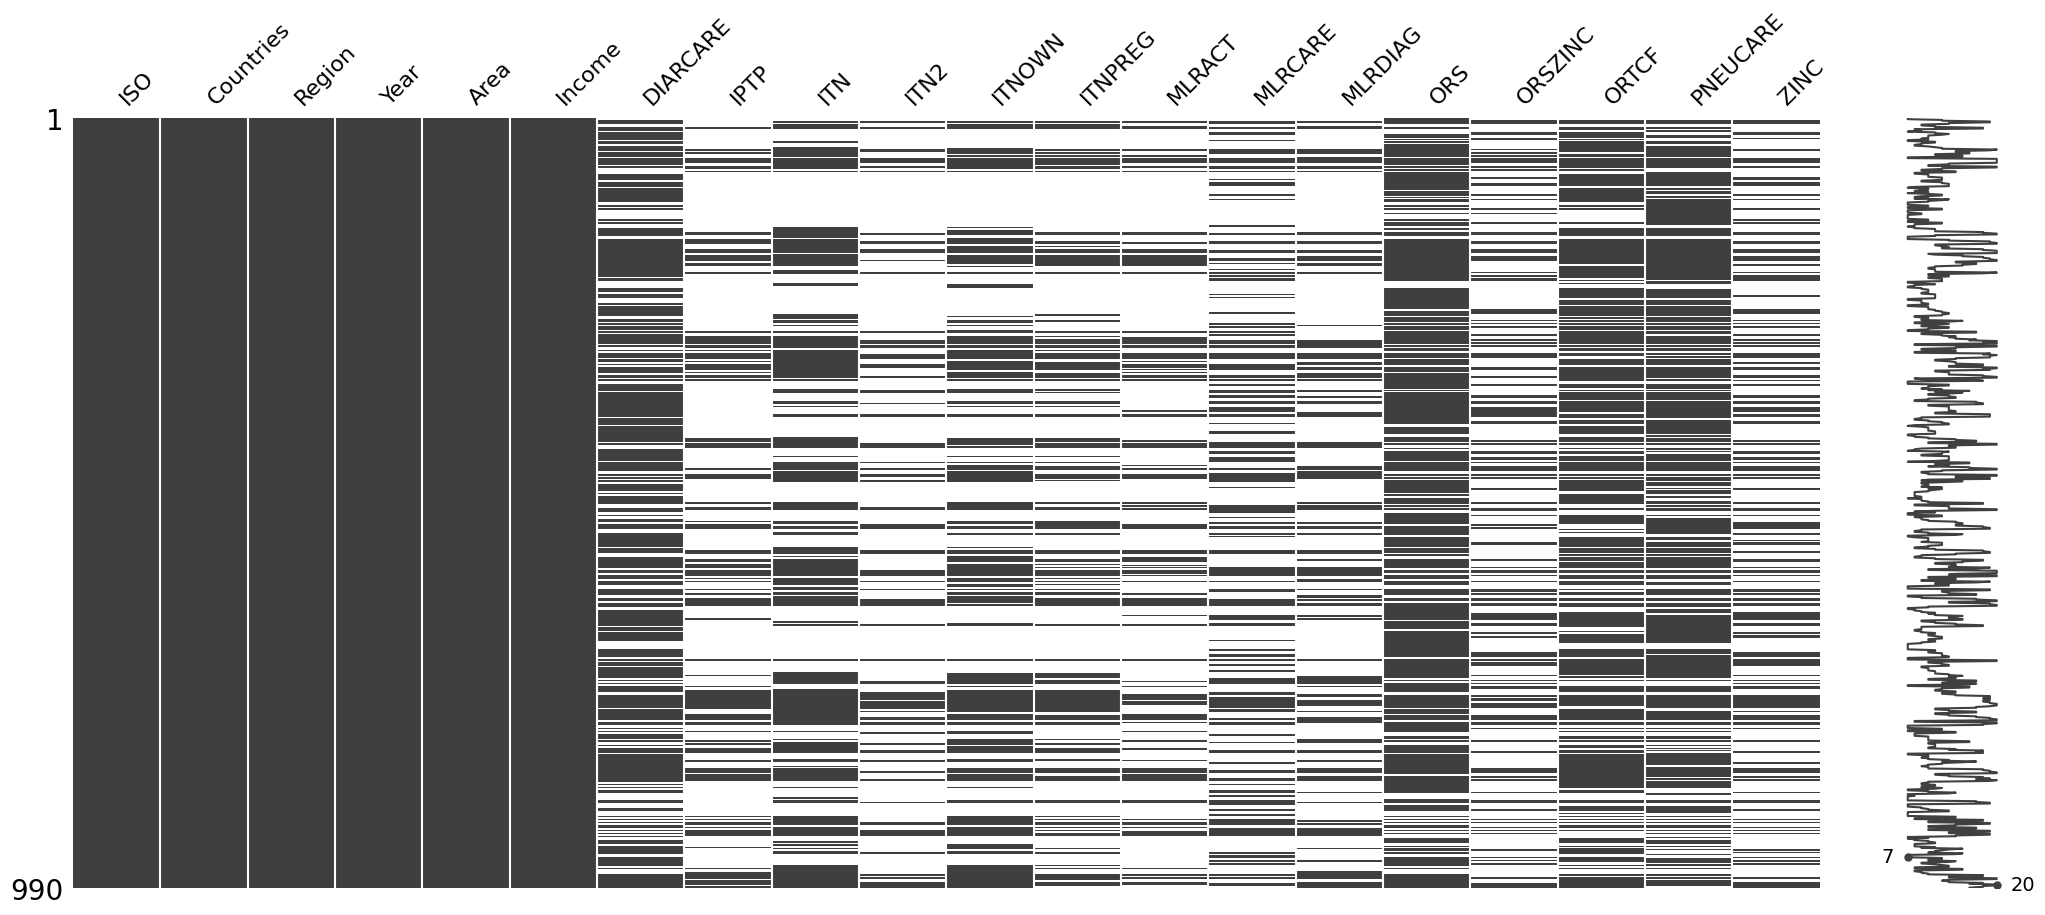

In [6]:
# just missing
msno.matrix(df0a)

# eak.
display((df0a.shape[0]-df0a.isna().sum().sort_values()))

<Axes: >

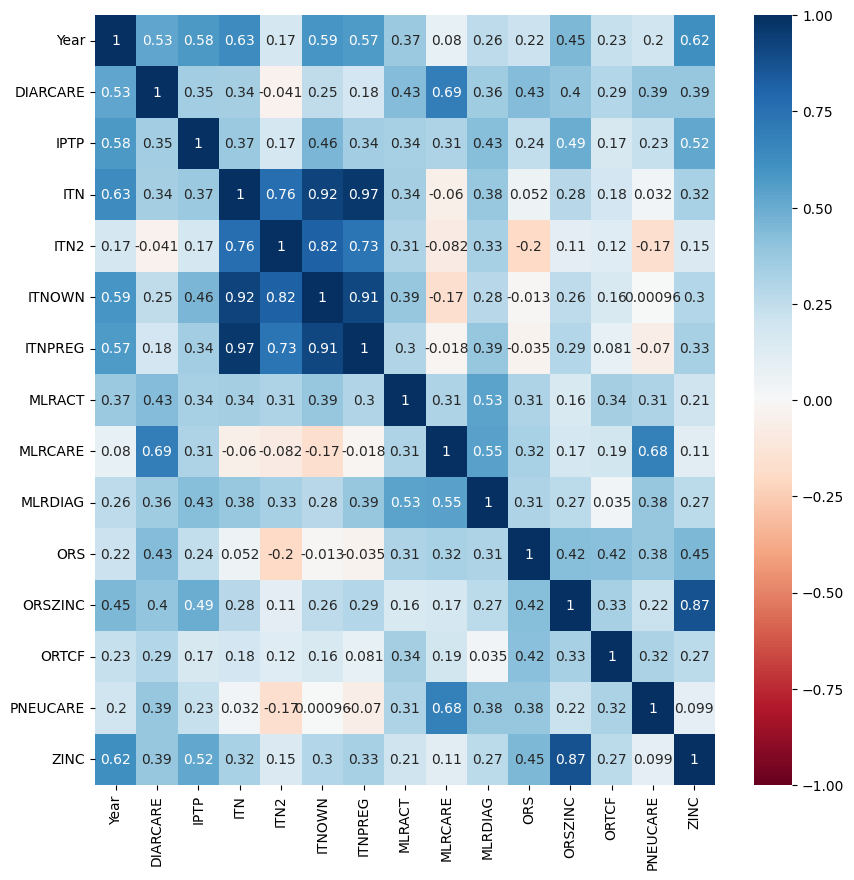

In [7]:
plt.figure(figsize=(10,10))
sns.heatmap(df0a.select_dtypes(exclude="object").corr(),  cmap="RdBu", vmin=-1, vmax=1, annot=True)

12

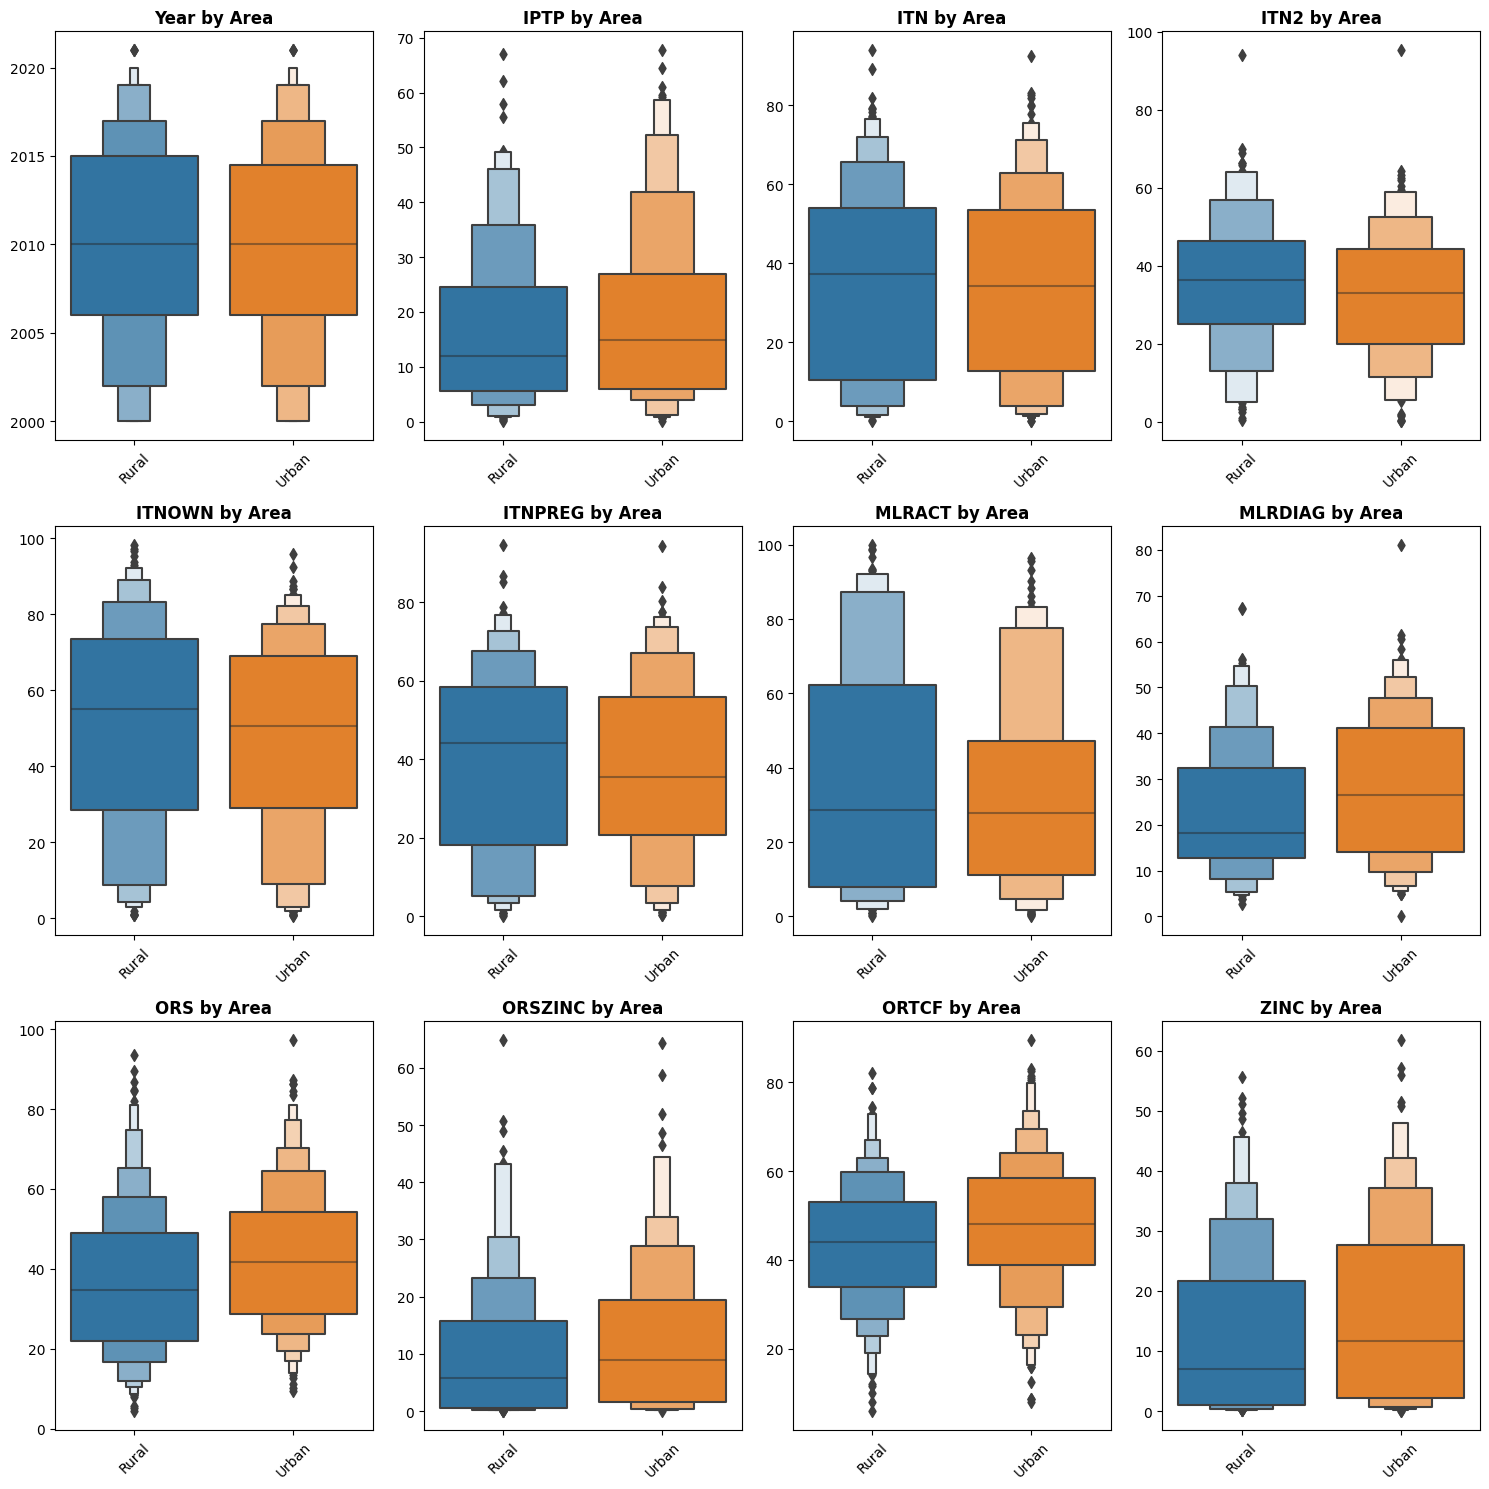

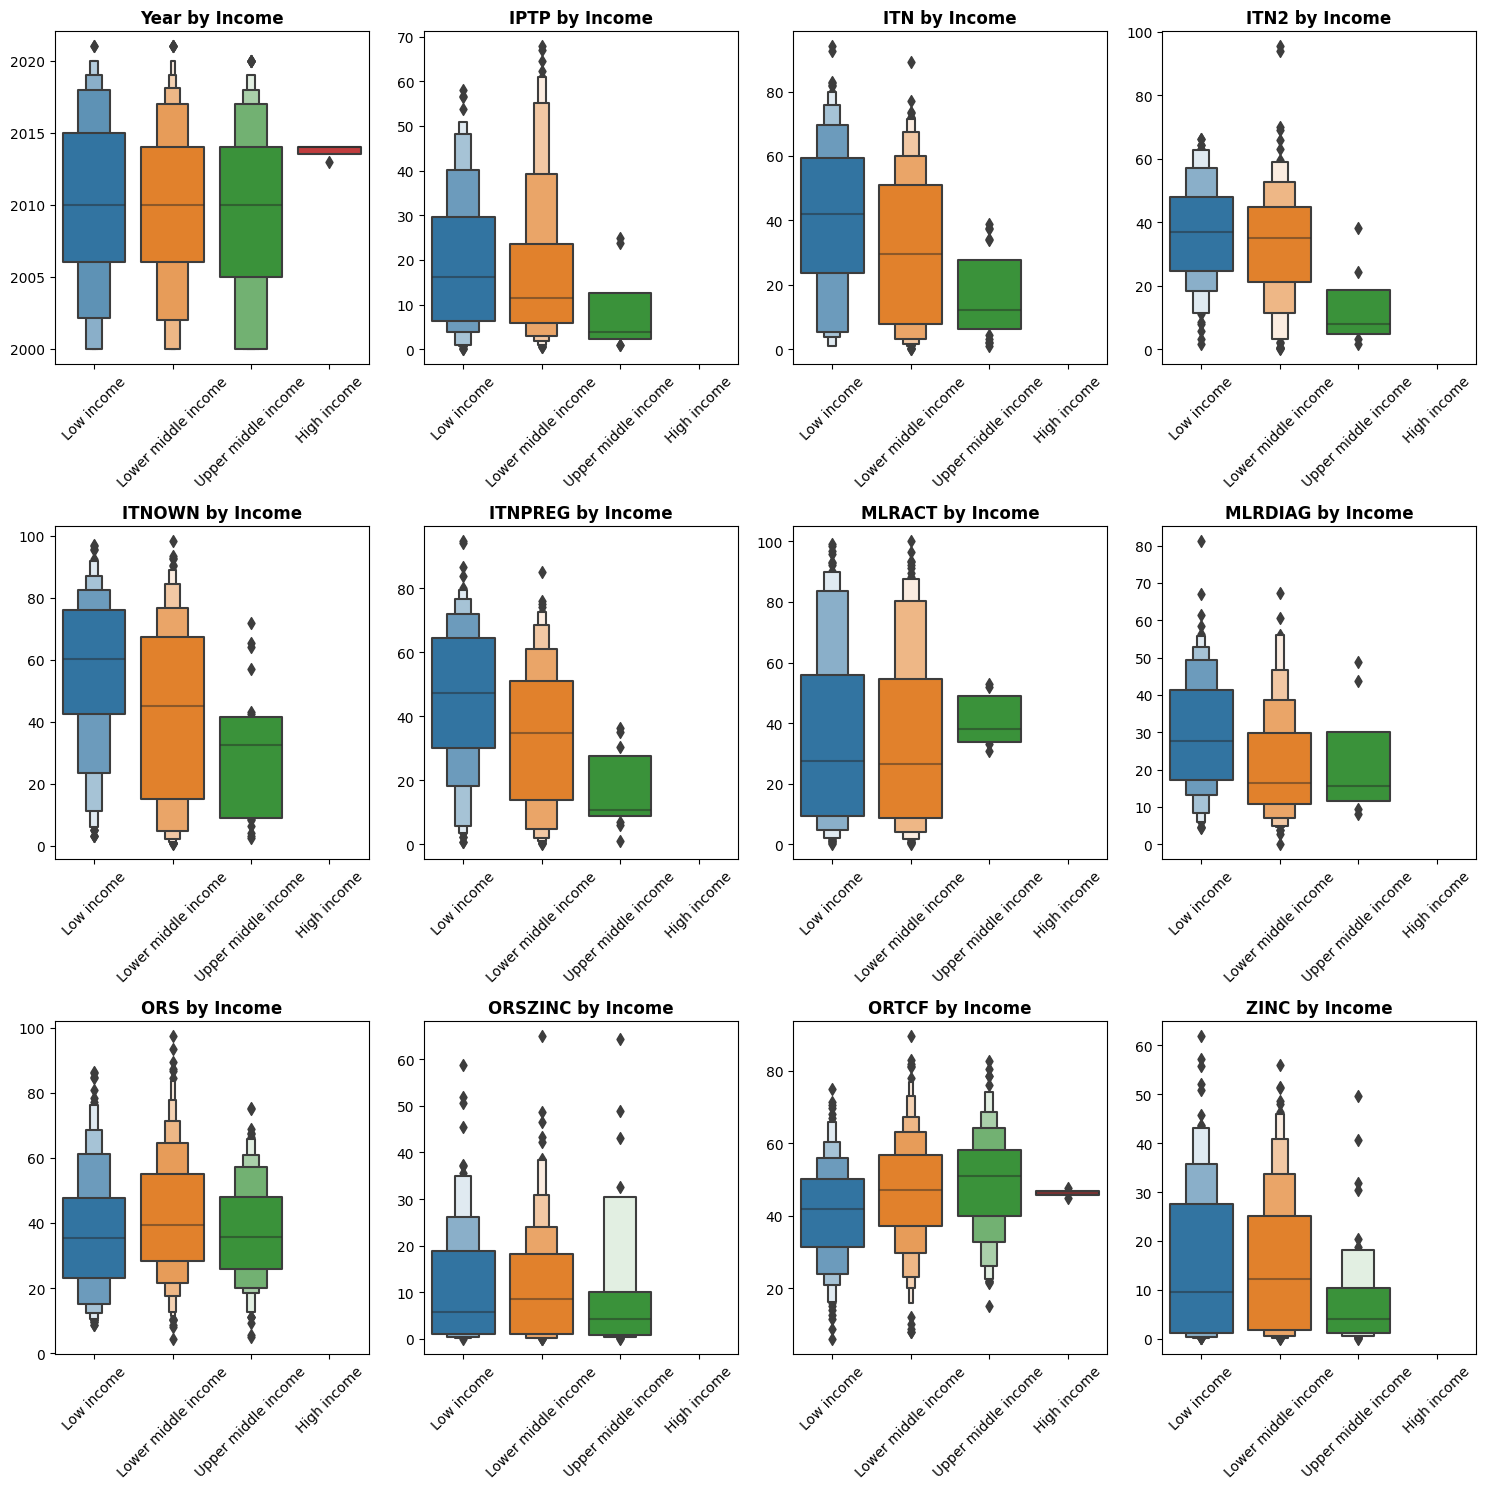

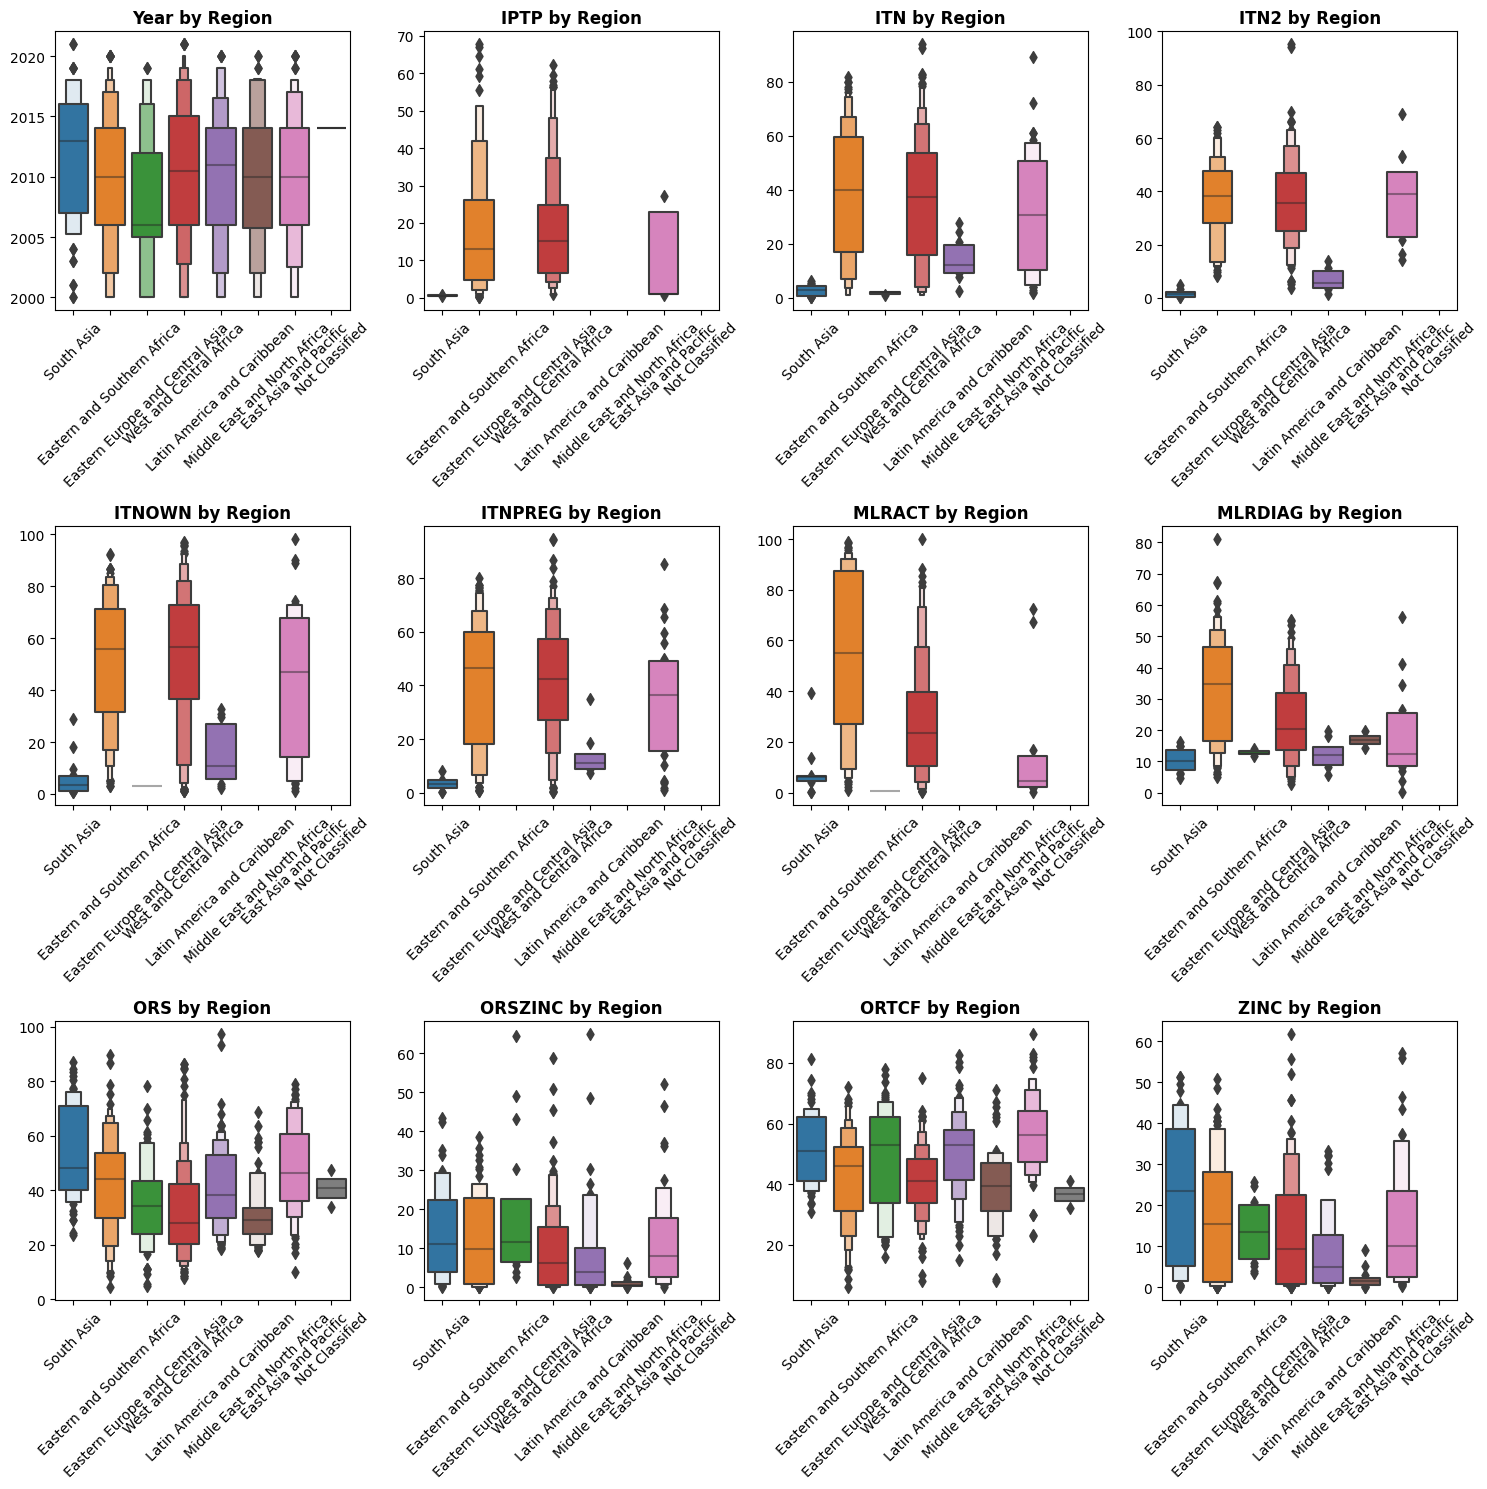

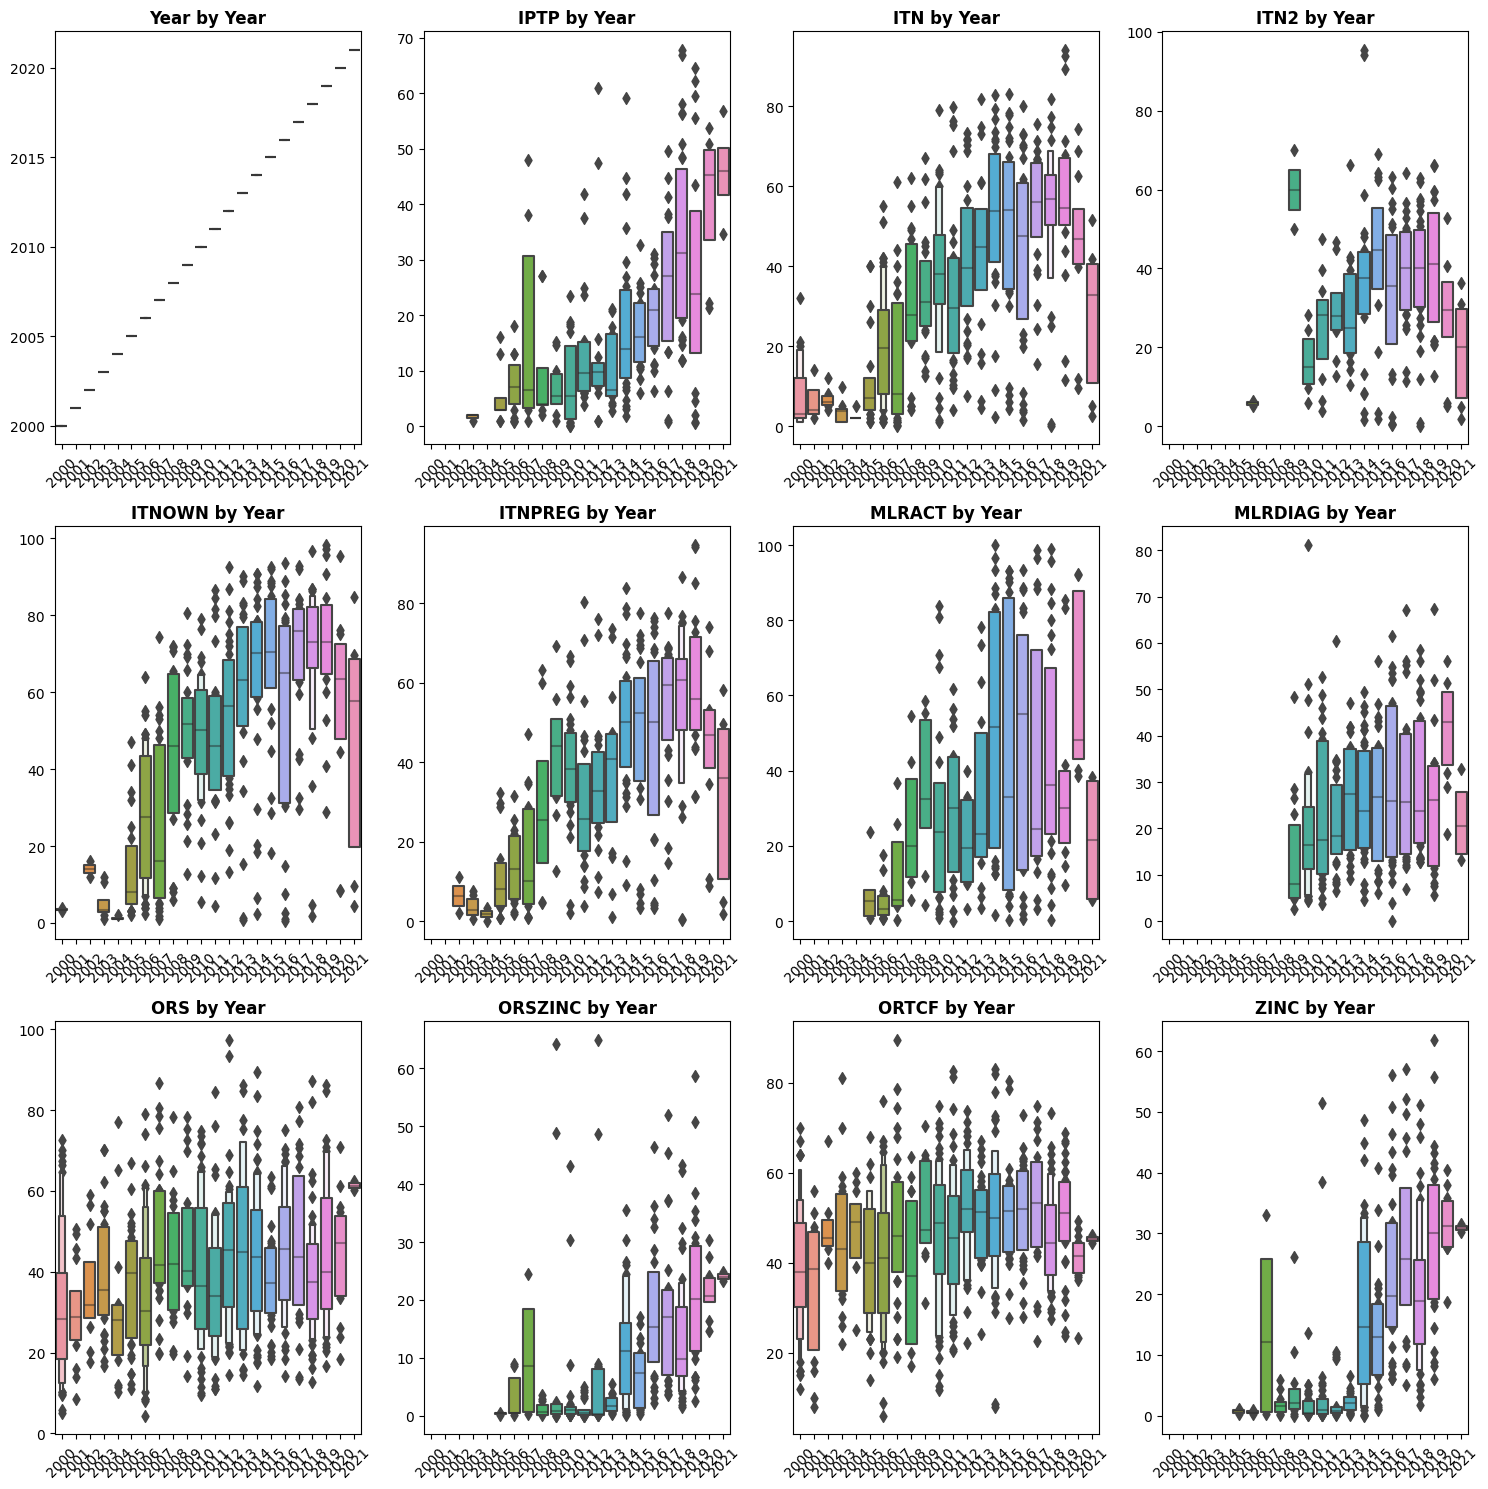

In [8]:
var0 = ["MLRCARE", "PNEUCARE", "DIARCARE"]
var1 = df0a.select_dtypes(exclude="object").columns
var1 = var1.drop(var0)

display(len(var1))

for j in "Area Income Region Year".split(" "):
    
    fig, axes = plt.subplots(3, 4, figsize=(15, 15), sharey=False)
    axes = axes.ravel()

    for i, var in enumerate(var1):
        sns.boxenplot(data=df0a, y=var, x=j, ax=axes[i])
        axes[i].set_title(f'{var} by {j}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(None)
        axes[i].set_ylabel('')
        axes[i].tick_params(axis='x', rotation=45)
        pass
    plt.tight_layout()

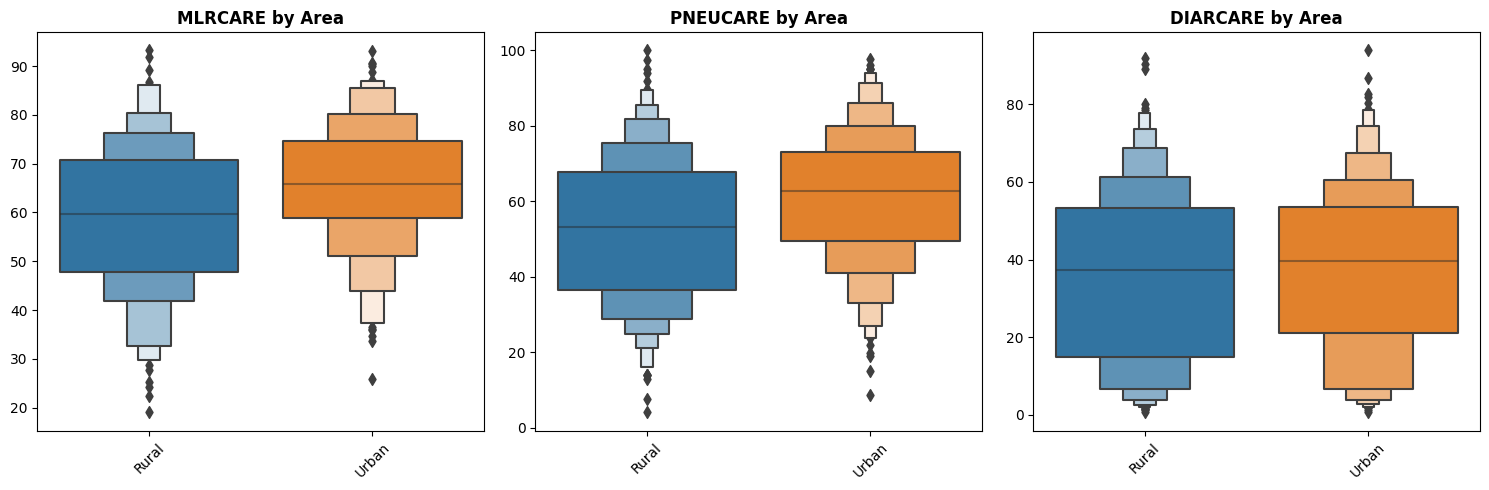

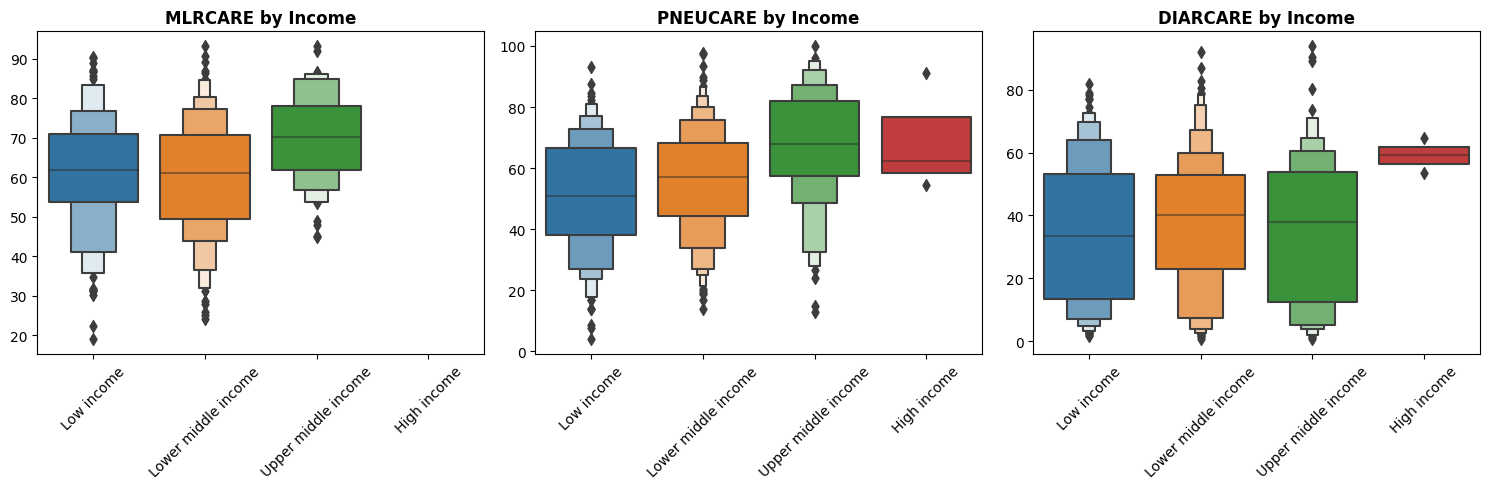

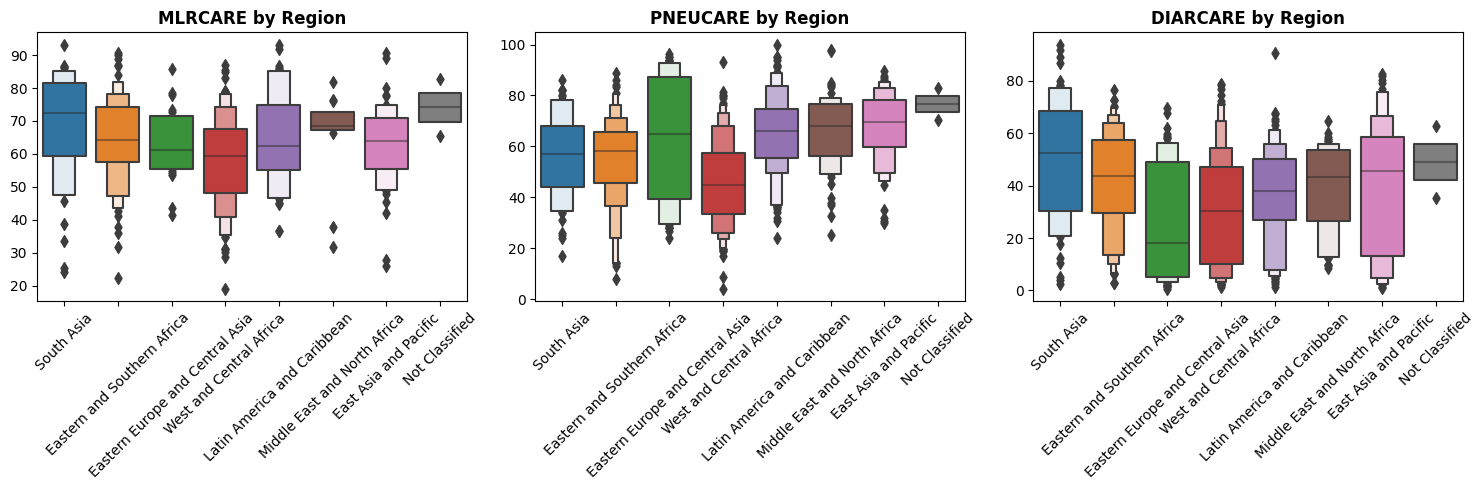

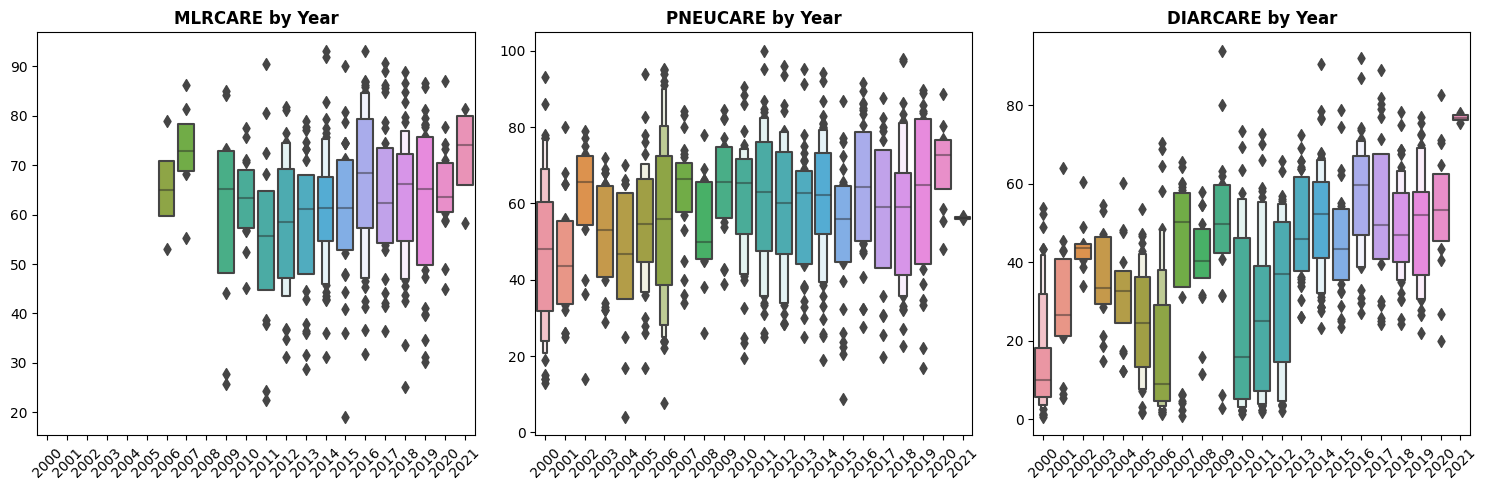

In [9]:
for j in "Area Income Region Year".split(" "):
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
    axes = axes.ravel()

    for i, var in enumerate(var0):
        sns.boxenplot(data=df0a, y=var, x=j, ax=axes[i])
        axes[i].set_title(f'{var} by {j}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(None)
        axes[i].set_ylabel('')
        axes[i].tick_params(axis='x', rotation=45)
        pass
    plt.tight_layout()

### Pre-Processing
Based on What?
1. Drop MLRDiag (Response Wannabe)
1. Pick 150 as test set from non NA responses
1.

In [10]:
sam_tr = df0a.isna().any(axis=1)
sam_te = ~sam_tr

# out mlrdiag
df0te = df0a[sam_te].drop(columns="MLRDIAG")
df0tr = df0a[sam_tr].drop(columns="MLRDIAG")

# df0tr imputated
df0tr.drop(columns=["MLRCARE", "DIARCARE", "PNEUCARE"])

# make a function? input dfte x only, xvar,
# do: split na non na, model non na, using RF, prepo and else
# impute for na
# done

,ISO,Countries,Region,Year,Area,Income,IPTP,ITN,ITN2,ITNOWN,ITNPREG,MLRACT,ORS,ORSZINC,ORTCF,ZINC
1,AFG,Afghanistan,South Asia,2003,Rural,Low income,NaN,NaN,NaN,NaN,NaN,NaN,24.3,NaN,NaN,NaN
2,AFG,Afghanistan,South Asia,2003,Urban,Low income,NaN,NaN,NaN,NaN,NaN,NaN,43.3,NaN,NaN,NaN
12,AFG,Afghanistan,South Asia,2011,Rural,Low income,NaN,NaN,NaN,NaN,NaN,NaN,54.2,4.4,48.9,5.4
14,AFG,Afghanistan,South Asia,2011,Urban,Low income,NaN,NaN,NaN,NaN,NaN,NaN,48.2,3.4,39.5,4.2
24,AFG,Afghanistan,South Asia,2015,Rural,Low income,NaN,4.2,3.3,28.7,3.4,6.6,47.1,8.2,41.0,10.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5470,ZWE,Zimbabwe,Eastern and Southern Africa,2011,Urban,Lower middle income,3.9,10.3,12.1,23.2,8.6,56.4,25.9,NaN,51.2,NaN
5492,ZWE,Zimbabwe,Eastern and Southern Africa,2015,Rural,Lower middle income,NaN,9.5,49.8,55.7,6.8,NaN,37.8,15.8,50.1,21.0
5495,ZWE,Zimbabwe,Eastern and Southern Africa,2015,Urban,Lower middle income,NaN,7.7,18.8,32.4,4.6,NaN,46.4,13.4,53.0,17.2
5503,ZWE,Zimbabwe,Eastern and Southern Africa,2019,Rural,Lower middle income,15.5,16.3,20.9,40.9,NaN,NaN,32.0,21.4,45.4,21.4


In [11]:
def fImputer(data=df0tr, varx="Region Year Income".split(" "), vary="IPTP"):
    dat1 = data[varx+[vary]]
    dtr1 = dat1.dropna()
    
    # x and y
    xtr1 = dtr1[varx]
    ytr1 = np.log1p(dtr1[vary])
    
    # PREPROCESS
    # kolom
    kol_kat = xtr1.columns
#     kol_num = xtr1.select_dtypes(exclude="object").columns
    
    # ordinal encoder, encoder and dummy-mean
    trf_kat = Pipeline(steps=[("kat_en", OneHotEncoder(handle_unknown='infrequent_if_exist'))])
#     trf_num = Pipeline(steps=[("num_im", SimpleImputer(strategy="median"))])
    
    # merge
    prepro = ColumnTransformer(transformers=[
        ('kat', trf_kat, kol_kat),
#         ('num', trf_num, kol_num)
    ])
    
    # model
    mod1 = imbpipeline(steps=[
        ("prepro", prepro),
        ("clf", LinearRegression())
    ])
    
    param_grid={
#         'clf__n_estimators': [50, 100],
#         'clf__min_samples_split': [2,3,4,5]
    }
    
    grid_mod1 = GridSearchCV(estimator=mod1, param_grid=param_grid, cv=3, 
                              scoring={"rsq": 'r2',
                                       "rmse": 'neg_root_mean_squared_error',
                                       "mae": 'neg_mean_absolute_error',
                                       "ev" : "explained_variance"
                                      }, 
                              verbose = 1, refit="rsq")
    
    grid_mod1.fit(xtr1, ytr1)
    
    # display metrix eval
    display(pd.DataFrame(grid_mod1.cv_results_).filter(regex='^mean',axis=1))
    j
    
    # predict dte1 and concat
    dte1 = dat1[dat1[vary].isna()]
    dte1.loc[:,vary] = np.exp(grid_mod1.predict(dte1))
    
    dall = pd.concat([dtr1,dte1]).sort_index()
    
    return dall

In [12]:
df1tr = df0tr.copy()

for j in var1.drop(["Year", "MLRDIAG"]):
    a = fImputer(vary=j)
    df1tr[j] = a[j]
    
df1tr = df1tr.drop(columns=['ISO', 'Countries', 'Region', 'Year', 'Income'])
df1tr["Area"] = df1tr.Area.replace(["Urban", "Rural"], [1,0])

Fitting 3 folds for each of 1 candidates, totalling 3 fits


,mean_fit_time,mean_score_time,mean_test_rsq,mean_test_rmse,mean_test_mae,mean_test_ev
0,0.01456,0.004597,0.00243,-0.966723,-0.72812,0.019102


Fitting 3 folds for each of 1 candidates, totalling 3 fits


,mean_fit_time,mean_score_time,mean_test_rsq,mean_test_rmse,mean_test_mae,mean_test_ev
0,0.01018,0.004971,0.458066,-0.781104,-0.59835,0.462937


Fitting 3 folds for each of 1 candidates, totalling 3 fits


,mean_fit_time,mean_score_time,mean_test_rsq,mean_test_rmse,mean_test_mae,mean_test_ev
0,0.009305,0.004182,0.316634,-0.684052,-0.557151,0.332049


Fitting 3 folds for each of 1 candidates, totalling 3 fits


,mean_fit_time,mean_score_time,mean_test_rsq,mean_test_rmse,mean_test_mae,mean_test_ev
0,0.01033,0.004475,0.437386,-0.686226,-0.524313,0.461054


Fitting 3 folds for each of 1 candidates, totalling 3 fits


,mean_fit_time,mean_score_time,mean_test_rsq,mean_test_rmse,mean_test_mae,mean_test_ev
0,0.009005,0.004719,0.223909,-0.869528,-0.644987,0.230362


Fitting 3 folds for each of 1 candidates, totalling 3 fits


,mean_fit_time,mean_score_time,mean_test_rsq,mean_test_rmse,mean_test_mae,mean_test_ev
0,0.009458,0.004676,0.2107,-1.066837,-0.812695,0.26615


Fitting 3 folds for each of 1 candidates, totalling 3 fits


,mean_fit_time,mean_score_time,mean_test_rsq,mean_test_rmse,mean_test_mae,mean_test_ev
0,0.009447,0.004401,0.03163,-0.47684,-0.391429,0.040679


Fitting 3 folds for each of 1 candidates, totalling 3 fits


,mean_fit_time,mean_score_time,mean_test_rsq,mean_test_rmse,mean_test_mae,mean_test_ev
0,0.009143,0.004472,0.07614,-1.156447,-0.906253,0.153416


Fitting 3 folds for each of 1 candidates, totalling 3 fits


,mean_fit_time,mean_score_time,mean_test_rsq,mean_test_rmse,mean_test_mae,mean_test_ev
0,0.010017,0.005435,-0.033971,-0.374955,-0.285854,-0.030207


Fitting 3 folds for each of 1 candidates, totalling 3 fits


,mean_fit_time,mean_score_time,mean_test_rsq,mean_test_rmse,mean_test_mae,mean_test_ev
0,0.011756,0.004661,0.411512,-0.970971,-0.772607,0.440633


<Axes: >

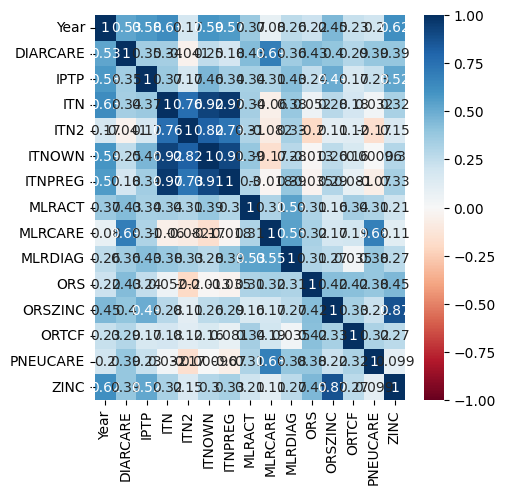

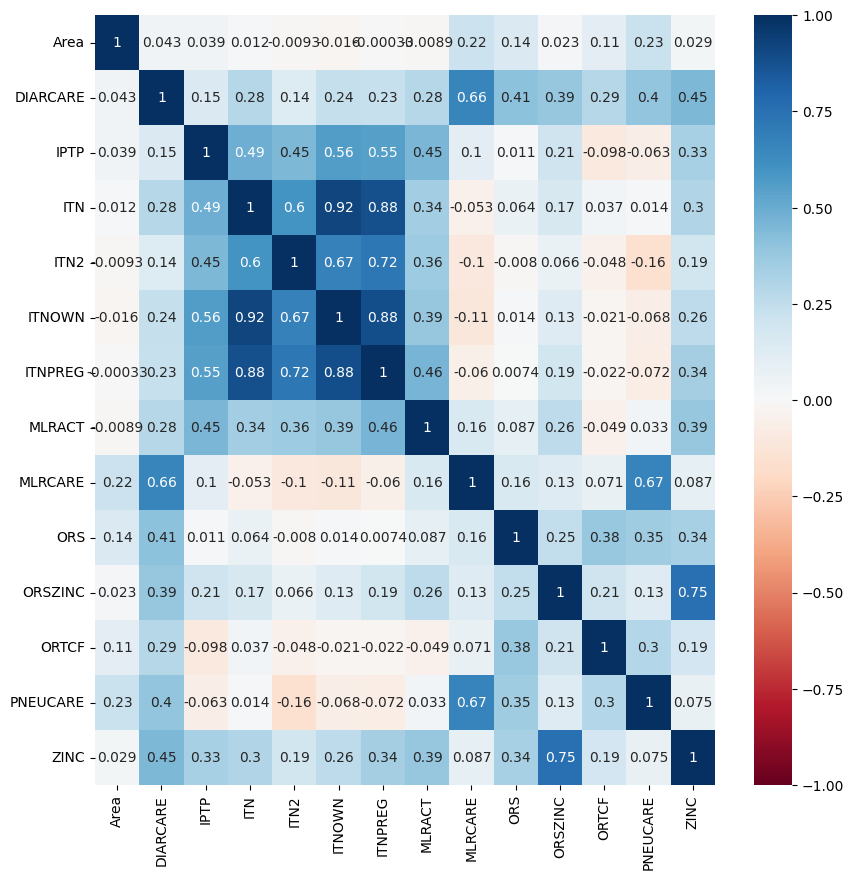

In [13]:
plt.figure(figsize=(5,5))
sns.heatmap(df0a.select_dtypes(exclude="object").corr(),  cmap="RdBu", vmin=-1, vmax=1, annot=True)

plt.figure(figsize=(10,10))
sns.heatmap(df1tr.select_dtypes(exclude="object").corr(), cmap="RdBu", vmin=-1, vmax=1, annot=True)

### Clean Predictor df1tr.
1. SO?
1. Split into MLRCARE, PNEUCARE, and DIARCARE

In [14]:
# from sklearn.preprocessing import OrdinalEncoder

# encoder = OrdinalEncoder()

# df1tr['Countries'] = encoder.fit_transform(df1tr[['Countries']])
# df0te['Countries'] = encoder.transform(df0te[['Countries']])

In [15]:
# df1tr

In [16]:
df0te
df1te = df0te.copy()
df1te["Area"] = df1te.Area.replace(["Urban", "Rural"], [1,0])

rkf = RepeatedKFold(n_splits=3, n_repeats=2, random_state=0)

In [17]:
TrP1 = df1tr.drop(columns=["DIARCARE", "MLRCARE"])
TrP2 = TrP1.dropna()

XP2 = TrP2.copy()
yP2 = XP2.pop("PNEUCARE")
# XP2 = XP2[['IPTP', 'ITN', 'ITN2', 'ITNOWN', 'ITNPREG']]

In [18]:
# Define a list of regression models
models = [
    LinearRegression(),
    Ridge(random_state=42),
    Lasso(random_state=42),
    ElasticNet(random_state=42),
    DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42),
    XGBRegressor(random_state=42),
    LGBMRegressor(random_state=42),
]

resP = []
eval1 = []

for model in models:
    pipa = imbpipeline(steps=[
        ("clf", model)
    ])
    
    grid= GridSearchCV(estimator=pipa, param_grid = {}, cv=rkf, scoring='r2', verbose=1)
    
    grid.fit(XP2, yP2)
    
    # Save the model's performance metrics in a dictionary
    result = {
        'Model': type(model).__name__,
        'RMSE1': grid.best_score_
    }
    
    yeah = r2_score(df1te["PNEUCARE"], grid.predict(df1te[XP2.columns]))
    
    result2 = {
        'Model': type(model).__name__,
        'Eval': yeah
    }
    
    # Append the dictionary to the results list
    resP.append(result)
    eval1.append(result2)
    pass

display(resP, eval1)

# for j in [mean_squared_error, r2_score, explained_variance_score]:
#     yeah = j(df1te["PNEUCARE"], grid.predict(df1te[XP2.columns]))
#     print(yeah)

Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits


[{'Model': 'LinearRegression', 'RMSE1': 0.20174761315445822},
 {'Model': 'Ridge', 'RMSE1': 0.2017598890838653},
 {'Model': 'Lasso', 'RMSE1': 0.19022559997855507},
 {'Model': 'ElasticNet', 'RMSE1': 0.1880326705190294},
 {'Model': 'DecisionTreeRegressor', 'RMSE1': -0.24987974996234055},
 {'Model': 'RandomForestRegressor', 'RMSE1': 0.3949094881168011},
 {'Model': 'GradientBoostingRegressor', 'RMSE1': 0.36213648972626133},
 {'Model': 'XGBRegressor', 'RMSE1': 0.2868209366677912},
 {'Model': 'LGBMRegressor', 'RMSE1': 0.3633132660682203}]

[{'Model': 'LinearRegression', 'Eval': 0.3038821600669135},
 {'Model': 'Ridge', 'Eval': 0.3040586417813248},
 {'Model': 'Lasso', 'Eval': 0.30572300046155965},
 {'Model': 'ElasticNet', 'Eval': 0.3069769087285238},
 {'Model': 'DecisionTreeRegressor', 'Eval': -0.4393143107582238},
 {'Model': 'RandomForestRegressor', 'Eval': 0.3540641862475824},
 {'Model': 'GradientBoostingRegressor', 'Eval': 0.40960150050200195},
 {'Model': 'XGBRegressor', 'Eval': 0.24917190083451113},
 {'Model': 'LGBMRegressor', 'Eval': 0.3477801603195887}]

In [19]:
TrD1 = df1tr.drop(columns=["PNEUCARE", "MLRCARE"])
TrD2 = TrD1.dropna()

XD2 = TrD2.copy()
yD2 = XD2.pop("DIARCARE")
# XD2 = XD2[['IPTP', 'ITN', 'ITN2', 'ITNOWN', 'ITNPREG']]

In [20]:
# Define a list of regression models
models = [
    LinearRegression(),
    Ridge(random_state=42),
    Lasso(random_state=42),
    ElasticNet(random_state=42),
    DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42),
    XGBRegressor(random_state=42),
    LGBMRegressor(random_state=42),
]

resD = []
eval2 = []

for model in models:
    pipa = imbpipeline(steps=[
        ("clf", model)
    ])
    
    grid= GridSearchCV(estimator=pipa, param_grid = {}, cv=rkf, scoring='r2', verbose=1)
    
    grid.fit(XD2, yD2)
    
    # Save the model's performance metrics in a dictionary
    result = {
        'Model': type(model).__name__,
        'RMSE1': grid.best_score_
    }
    
    yeah = r2_score(df1te["DIARCARE"], grid.predict(df1te[XD2.columns]))
    
    result2 = {
        'Model': type(model).__name__,
        'Eval': yeah
    }
    
    # Append the dictionary to the results list
    resD.append(result)
    eval2.append(result2)
    pass

display(resD, eval2)

# for j in [mean_squared_error, r2_score, explained_variance_score]:
#     yeah = j(df1te["DIARCARE"], grid.predict(df1te[XD2.columns]))
#     print(yeah)

Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits


[{'Model': 'LinearRegression', 'RMSE1': 0.3001123433619913},
 {'Model': 'Ridge', 'RMSE1': 0.3001277639359032},
 {'Model': 'Lasso', 'RMSE1': 0.30205335655063653},
 {'Model': 'ElasticNet', 'RMSE1': 0.30170816905021763},
 {'Model': 'DecisionTreeRegressor', 'RMSE1': 0.08136254810409761},
 {'Model': 'RandomForestRegressor', 'RMSE1': 0.5234298729963348},
 {'Model': 'GradientBoostingRegressor', 'RMSE1': 0.49030155113307566},
 {'Model': 'XGBRegressor', 'RMSE1': 0.43663743546712475},
 {'Model': 'LGBMRegressor', 'RMSE1': 0.5001352967471853}]

[{'Model': 'LinearRegression', 'Eval': 0.430460190672454},
 {'Model': 'Ridge', 'Eval': 0.4304300629305191},
 {'Model': 'Lasso', 'Eval': 0.4322549553035283},
 {'Model': 'ElasticNet', 'Eval': 0.4300325049718894},
 {'Model': 'DecisionTreeRegressor', 'Eval': -0.3696370973583891},
 {'Model': 'RandomForestRegressor', 'Eval': 0.34335563039718586},
 {'Model': 'GradientBoostingRegressor', 'Eval': 0.17506378861309357},
 {'Model': 'XGBRegressor', 'Eval': 0.07081516230122376},
 {'Model': 'LGBMRegressor', 'Eval': 0.16369367978696814}]

In [21]:
TrM1 = df1tr.drop(columns=["PNEUCARE", "DIARCARE"])
TrM2 = TrM1.dropna()

XM2 = TrM2.copy()
yM2 = XM2.pop("MLRCARE")
# XM2 = XM2[['IPTP', 'ITN', 'ITN2', 'ITNOWN', 'ITNPREG']]

In [22]:
# Define a list of regression models
models = [
    LinearRegression(),
    Ridge(random_state=42),
    Lasso(random_state=42),
    ElasticNet(random_state=42),
    DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42),
    XGBRegressor(random_state=42),
    LGBMRegressor(random_state=42),
]

resM = []
eval3 = []

for model in models:
    pipa = imbpipeline(steps=[
        ("clf", model)
    ])
    
    grid= GridSearchCV(estimator=pipa, param_grid = {}, cv=rkf, scoring='r2', verbose=1)
    
    grid.fit(XM2, yM2)
    
    # Save the model's performance metrics in a dictionary
    result = {
        'Model': type(model).__name__,
        'RMSE1': grid.best_score_
    }
    
    yeah = r2_score(df1te["MLRCARE"], grid.predict(df1te[XM2.columns]))
    
    result2 = {
        'Model': type(model).__name__,
        'Eval': yeah
    }
    
    # Append the dictionary to the results list
    resM.append(result)
    eval3.append(result2)
    pass

display(resM, eval3)

# for j in [mean_squared_error, r2_score, explained_variance_score]:
#     yeah = j(df1te["MLRCARE"], grid.predict(df1te[XM2.columns]))
#     print(yeah)

Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits


[{'Model': 'LinearRegression', 'RMSE1': 0.05808267915483798},
 {'Model': 'Ridge', 'RMSE1': 0.05856735498230085},
 {'Model': 'Lasso', 'RMSE1': 0.04207801948554699},
 {'Model': 'ElasticNet', 'RMSE1': 0.05028937104054718},
 {'Model': 'DecisionTreeRegressor', 'RMSE1': -0.3302220656468449},
 {'Model': 'RandomForestRegressor', 'RMSE1': 0.22554415821089094},
 {'Model': 'GradientBoostingRegressor', 'RMSE1': 0.13875489475833916},
 {'Model': 'XGBRegressor', 'RMSE1': 0.09694298086813392},
 {'Model': 'LGBMRegressor', 'RMSE1': 0.15422729154188672}]

[{'Model': 'LinearRegression', 'Eval': 0.118617391046836},
 {'Model': 'Ridge', 'Eval': 0.11867081712258953},
 {'Model': 'Lasso', 'Eval': 0.09181130715770802},
 {'Model': 'ElasticNet', 'Eval': 0.09631146833403836},
 {'Model': 'DecisionTreeRegressor', 'Eval': -0.5390272922588619},
 {'Model': 'RandomForestRegressor', 'Eval': 0.17585773228916723},
 {'Model': 'GradientBoostingRegressor', 'Eval': 0.10454962753523467},
 {'Model': 'XGBRegressor', 'Eval': -0.07490788394644565},
 {'Model': 'LGBMRegressor', 'Eval': -0.0687497314646679}]

## Labelling

In [23]:
# df2tr = df1tr.copy()
# df2te = df1te.copy()
# df2tr.head()

# XP3 = TrP1[TrP1.PNEUCARE.isna()]
# yP3 = XP3.pop("PNEUCARE")

# XD3 = TrD1[TrD1.DIARCARE.isna()]
# yD3 = XD3.pop("DIARCARE")

# XM3 = TrM1[TrM1.MLRCARE.isna()]
# yM3 = XM3.pop("MLRCARE")

# models = [RandomForestRegressor(random_state=42)]
# pipa = imbpipeline(steps=[("clf", model)])
# grid= GridSearchCV(estimator=pipa, param_grid = {}, cv=rkf, scoring='r2', verbose=1)
# grid.fit(XP2, yP2)
# df2tr.loc[df2tr.PNEUCARE.isna(), "PNEUCARE"] = grid.predict(XP3)

# models = [RandomForestRegressor(random_state=42)]
# pipa = imbpipeline(steps=[("clf", model)])
# grid= GridSearchCV(estimator=pipa, param_grid = {}, cv=rkf, scoring='r2', verbose=1)
# grid.fit(XD2, yD2)
# df2tr.loc[df2tr.DIARCARE.isna(), "DIARCARE"]  = grid.predict(XD3)

# models = [RandomForestRegressor(random_state=42)]
# pipa = imbpipeline(steps=[("clf", model)])
# grid= GridSearchCV(estimator=pipa, param_grid = {}, cv=rkf, scoring='r2', verbose=1)
# grid.fit(XM2, yM2)
# df2tr.loc[df2tr.MLRCARE.isna(), "MLRCARE"] = grid.predict(XM3)

# display(df2tr.head())

# df = pd.concat([df2tr, df2te.drop(columns = "ISO Countries Region Year Income".split(" "))], ignore_index=True)
# display(df.head(), df.info())

In [24]:
# df2tr.isna().sum()

In [25]:
# TrP1 = df.drop(columns=["DIARCARE", "MLRCARE"])
# # TrP1 = df2tr.drop(columns=["DIARCARE", "MLRCARE"])
# TrP2 = TrP1.dropna()

# XP2 = TrP2.copy()
# yP2 = XP2.pop("PNEUCARE")

In [26]:
# models = [
#     LinearRegression(),
#     Ridge(random_state=42),
#     Lasso(random_state=42),
#     ElasticNet(random_state=42),
#     DecisionTreeRegressor(random_state=42),
#     RandomForestRegressor(random_state=42),
#     GradientBoostingRegressor(random_state=42),
#     XGBRegressor(random_state=42),
#     LGBMRegressor(random_state=42),
# ]

# resP = []

# for model in models:
#     pipa = imbpipeline(steps=[
#         ("clf", model)
#     ])
    
#     grid= GridSearchCV(estimator=pipa, param_grid = {}, cv=rkf, scoring='r2', verbose=1)
    
#     grid.fit(XP2, yP2)
    
#     # Save the model's performance metrics in a dictionary
#     result = {
#         'Model': type(model).__name__,
#         'RMSE1': grid.best_score_
#     }
    
#     # Append the dictionary to the results list
#     resP.append(result)
#     pass

# display(resP)

# # for j in [mean_squared_error, r2_score, explained_variance_score]:
# #     yeah = j(df2te["PNEUCARE"], grid.predict(df2te[XP2.columns]))
# #     print(yeah)

In [27]:
# TrD1 = df.drop(columns=["PNEUCARE", "MLRCARE"])
# # TrD1 = df2tr.drop(columns=["PNEUCARE", "MLRCARE"])
# TrD2 = TrD1.dropna()

# XD2 = TrD2.copy()
# yD2 = XD2.pop("DIARCARE")

In [28]:
# models = [
#     LinearRegression(),
#     Ridge(random_state=42),
#     Lasso(random_state=42),
#     ElasticNet(random_state=42),
#     DecisionTreeRegressor(random_state=42),
#     RandomForestRegressor(random_state=42),
#     GradientBoostingRegressor(random_state=42),
#     XGBRegressor(random_state=42),
#     LGBMRegressor(random_state=42),
# ]

# resD = []

# for model in models:
#     pipa = imbpipeline(steps=[
#         ("clf", model)
#     ])
    
#     grid= GridSearchCV(estimator=pipa, param_grid = {}, cv=rkf, scoring='r2', verbose=1)
    
#     grid.fit(XD2, yD2)
    
#     # Save the model's performance metrics in a dictionary
#     result = {
#         'Model': type(model).__name__,
#         'RMSE1': grid.best_score_
#     }
    
#     # Append the dictionary to the results list
#     resD.append(result)
#     pass

# display(resD)

# # for j in [mean_squared_error, r2_score, explained_variance_score]:
# #     yeah = j(df2te["DIARCARE"], grid.predict(df2te[XD2.columns]))
# #     print(yeah)

In [29]:
# TrM1 = df.drop(columns=["PNEUCARE", "DIARCARE"])
# # TrM1 = df2tr.drop(columns=["PNEUCARE", "DIARCARE"])
# TrM2 = TrM1.dropna()

# XM2 = TrM2.copy()
# yM2 = XM2.pop("MLRCARE")

In [30]:
# models = [
#     LinearRegression(),
#     Ridge(random_state=42),
#     Lasso(random_state=42),
#     ElasticNet(random_state=42),
#     DecisionTreeRegressor(random_state=42),
#     RandomForestRegressor(random_state=42),
#     GradientBoostingRegressor(random_state=42),
#     XGBRegressor(random_state=42),
#     LGBMRegressor(random_state=42),
# ]

# resM = []

# for model in models:
#     pipa = imbpipeline(steps=[
#         ("clf", model)
#     ])
    
#     grid= GridSearchCV(estimator=pipa, param_grid = {}, cv=rkf, scoring='r2', verbose=1)
    
#     grid.fit(XM2, yM2)
    
#     # Save the model's performance metrics in a dictionary
#     result = {
#         'Model': type(model).__name__,
#         'RMSE1': grid.best_score_
#     }
    
#     # Append the dictionary to the results list
#     resM.append(result)
#     pass

# display(resM)

# # for j in [mean_squared_error, r2_score, explained_variance_score]:
# #     yeah = j(df2te["MLRCARE"], grid.predict(df2te[XN2.columns]))
# #     print(yeah)

## Imputasi Lain Cara

In [31]:
# uhuu, response imputation
df0b = df0a.copy()
df0b.MLRCARE.fillna(df0a.groupby(["Year", "Income", "Region"])["MLRCARE"].transform("median"), inplace=True)
display(df0b.isna().sum()/df0b.shape[0]*100)

# impute predictor using unused predictors
for j in var1.drop(["MLRDIAG", "Year"]):
    df0b[j].fillna(df0a.groupby(["Year", "Income", "Region"])[j].transform("median"), inplace=True)
    pass

# df0b = df0b[~df0b[["MLRCARE", "PNEUCARE", "DIARCARE"]].isna().any(axis=1)].drop(columns="MLRDIAG")
df0b = df0b.drop(columns="MLRDIAG")
df0b
# 329 EAK ehm 75 :?? --> 172
display(df0b.dropna().shape)
display(df0b.isna().sum()/df0b.shape[0]*100)

# 2nd imputation
for j in var1.drop(["MLRDIAG", "Year"]):
    df0b[j].fillna(df0a.groupby(["Income", "Region"])[j].transform("median"), inplace=True)
    pass

# eak
display(df0b.dropna().shape)
display(df0b.isna().sum()/df0b.shape[0]*100)

# 3rd imputation
for j in var1.drop(["MLRDIAG", "Year"]):
    df0b[j].fillna(df0a.groupby(["Income"])[j].transform("median"), inplace=True)
    pass

# eak
display(df0b.dropna().shape)
display(df0b.isna().sum()/df0b.shape[0]*100)
df0b.dropna(subset=df0b.columns.difference(['DIARCARE', "MLRCARE", 'PNEUCARE']), inplace=True)

ISO           0.000000
Countries     0.000000
Region        0.000000
Year          0.000000
Area          0.000000
Income        0.000000
DIARCARE     30.000000
IPTP         72.323232
ITN          51.313131
ITN2         79.797980
ITNOWN       55.858586
ITNPREG      66.767677
MLRACT       75.555556
MLRCARE      47.171717
MLRDIAG      71.919192
ORS          23.535354
ORSZINC      69.393939
ORTCF        31.111111
PNEUCARE     28.989899
ZINC         65.858586
dtype: float64

(172, 19)

ISO           0.000000
Countries     0.000000
Region        0.000000
Year          0.000000
Area          0.000000
Income        0.000000
DIARCARE     30.000000
IPTP         59.696970
ITN          38.080808
ITN2         67.373737
ITNOWN       44.545455
ITNPREG      50.404040
MLRACT       57.878788
MLRCARE      47.171717
ORS           6.969697
ORSZINC      47.373737
ORTCF        11.212121
PNEUCARE     28.989899
ZINC         48.181818
dtype: float64

(255, 19)

ISO           0.000000
Countries     0.000000
Region        0.000000
Year          0.000000
Area          0.000000
Income        0.000000
DIARCARE     30.000000
IPTP         34.444444
ITN           8.787879
ITN2         17.878788
ITNOWN       15.454545
ITNPREG      17.878788
MLRACT       31.212121
MLRCARE      47.171717
ORS           0.303030
ORSZINC       2.727273
ORTCF         0.101010
PNEUCARE     28.989899
ZINC          1.717172
dtype: float64

(329, 19)

ISO           0.000000
Countries     0.000000
Region        0.000000
Year          0.000000
Area          0.000000
Income        0.000000
DIARCARE     30.000000
IPTP          0.303030
ITN           0.303030
ITN2          0.303030
ITNOWN        0.303030
ITNPREG       0.303030
MLRACT        0.303030
MLRCARE      47.171717
ORS           0.303030
ORSZINC       0.303030
ORTCF         0.000000
PNEUCARE     28.989899
ZINC          0.303030
dtype: float64

In [32]:
df0b.isna().sum()
df0b.shape

(987, 19)

In [33]:
# df0c = df0b.loc[:,df1tr.columns]
# df0c.head()
# df0c["Area"] = df0c.Area.replace(["Urban", "Rural"], [1,0])

# df3te = df0c[sam_te[sam_te.index.isin(df0c.index)]]
# df3tr = df0c[sam_tr[sam_tr.index.isin(df0c.index)]]

# TrP3 = df3tr.drop(columns=["MLRCARE", "DIARCARE"])
# TrP3 = TrP3.dropna()
# XP3 = TrP3.copy()
# yP3 = XP3.pop("PNEUCARE")

# TrD3 = df3tr.drop(columns=["PNEUCARE", "MLRCARE"])
# TrD3 = TrD3.dropna()
# XD3 = TrD3.copy()
# yD3 = XD3.pop("DIARCARE")

# TrM3 = df3tr.drop(columns=["PNEUCARE", "DIARCARE"])
# TrM3 = TrM3.dropna()
# XM3 = TrM3.copy()
# yM3 = XM3.pop("MLRCARE")

In [34]:
# # Define a list of regression models
# models = [
#     LinearRegression(),
#     Ridge(random_state=42),
#     Lasso(random_state=42),
#     ElasticNet(random_state=42),
#     DecisionTreeRegressor(random_state=42),
#     RandomForestRegressor(random_state=42),
#     GradientBoostingRegressor(random_state=42),
#     XGBRegressor(random_state=42),
#     LGBMRegressor(random_state=42),
# ]

# resP = []
# eval1 = []

# for model in models:
#     pipa = imbpipeline(steps=[
#         ("clf", model)
#     ])
    
#     grid= GridSearchCV(estimator=pipa, param_grid = {}, cv=rkf, scoring='r2', verbose=1)
    
#     grid.fit(XP3, yP3)
    
#     # Save the model's performance metrics in a dictionary
#     result = {
#         'Model': type(model).__name__,
#         'RMSE1': grid.best_score_
#     }
    
#     yeah = r2_score(df3te["PNEUCARE"], grid.predict(df3te[XP3.columns]))
    
#     result2 = {
#         'Model': type(model).__name__,
#         'Eval': yeah
#     }
    
#     # Append the dictionary to the results list
#     resP.append(result)
#     eval1.append(result2)
#     pass

# display(resP, eval1)

# # for j in [mean_squared_error, r2_score, explained_variance_score]:
# #     yeah = j(df1te["PNEUCARE"], grid.predict(df1te[XP2.columns]))
# #     print(yeah)

In [35]:
# # Define a list of regression models
# models = [
#     LinearRegression(),
#     Ridge(random_state=42),
#     Lasso(random_state=42),
#     ElasticNet(random_state=42),
#     DecisionTreeRegressor(random_state=42),
#     RandomForestRegressor(random_state=42),
#     GradientBoostingRegressor(random_state=42),
#     XGBRegressor(random_state=42),
#     LGBMRegressor(random_state=42),
# ]

# resD = []
# eval2 = []

# for model in models:
#     pipa = imbpipeline(steps=[
#         ("clf", model)
#     ])
    
#     grid= GridSearchCV(estimator=pipa, param_grid = {}, cv=rkf, scoring='r2', verbose=1)
    
#     grid.fit(XD3, yD3)
    
#     # Save the model's performance metrics in a dictionary
#     result = {
#         'Model': type(model).__name__,
#         'RMSE1': grid.best_score_
#     }
    
#     yeah = r2_score(df3te["DIARCARE"], grid.predict(df3te[XD3.columns]))
    
#     result2 = {
#         'Model': type(model).__name__,
#         'Eval': yeah
#     }
    
#     # Append the dictionary to the results list
#     resD.append(result)
#     eval2.append(result2)
#     pass

# display(resD, eval2)

# # for j in [mean_squared_error, r2_score, explained_variance_score]:
# #     yeah = j(df1te["DIARCARE"], grid.predict(df1te[XD2.columns]))
# #     print(yeah)

In [36]:
# # Define a list of regression models
# models = [
#     LinearRegression(),
#     Ridge(random_state=42),
#     Lasso(random_state=42),
#     ElasticNet(random_state=42),
#     DecisionTreeRegressor(random_state=42),
#     RandomForestRegressor(random_state=42),
#     GradientBoostingRegressor(random_state=42),
#     XGBRegressor(random_state=42),
#     LGBMRegressor(random_state=42),
# ]

# resM = []
# eval3 = []

# for model in models:
#     pipa = imbpipeline(steps=[
#         ("clf", model)
#     ])
    
#     grid= GridSearchCV(estimator=pipa, param_grid = {}, cv=rkf, scoring='r2', verbose=1)
    
#     grid.fit(XM3, yM3)
    
#     # Save the model's performance metrics in a dictionary
#     result = {
#         'Model': type(model).__name__,
#         'RMSE1': grid.best_score_
#     }
    
#     yeah = r2_score(df3te["MLRCARE"], grid.predict(df3te[XM3.columns]))
    
#     result2 = {
#         'Model': type(model).__name__,
#         'Eval': yeah
#     }
    
#     # Append the dictionary to the results list
#     resM.append(result)
#     eval3.append(result2)
#     pass

# display(resM, eval3)

# # for j in [mean_squared_error, r2_score, explained_variance_score]:
# #     yeah = j(df1te["MLRCARE"], grid.predict(df1te[XM2.columns]))
# #     print(yeah)

## Labelling

In [37]:
# df4tr = df3tr.copy()
# df4te = df3te.copy()
# df4tr.head()

# TrP4 = df4tr.drop(columns=["MLRCARE", "DIARCARE"])
# XP4 = TrP4[TrP4.PNEUCARE.isna()]
# yP4 = XP4.pop("PNEUCARE")

# TrD4 = df4tr.drop(columns=["MLRCARE", "PNEUCARE"])
# XD4 = TrD4[TrD4.DIARCARE.isna()]
# yD4 = XD4.pop("DIARCARE")

# TrM4 = df4tr.drop(columns=["DIARCARE", "PNEUCARE"])
# XM4 = TrM4[TrM4.MLRCARE.isna()]
# yM4 = XM4.pop("MLRCARE")

# models = [LGBMRegressor(random_state=42)]
# pipa = imbpipeline(steps=[("clf", model)])
# grid= GridSearchCV(estimator=pipa, param_grid = {}, cv=rkf, scoring='r2', verbose=1)
# grid.fit(XP3, yP3)
# df4tr.loc[df4tr.PNEUCARE.isna(), "PNEUCARE"] = grid.predict(XP4)

# models = [RandomForestRegressor(random_state=42)]
# pipa = imbpipeline(steps=[("clf", model)])
# grid= GridSearchCV(estimator=pipa, param_grid = {}, cv=rkf, scoring='r2', verbose=1)
# grid.fit(XD3, yD3)
# df4tr.loc[df4tr.DIARCARE.isna(), "DIARCARE"]  = grid.predict(XD4)

# models = [RandomForestRegressor(random_state=42)]
# pipa = imbpipeline(steps=[("clf", model)])
# grid= GridSearchCV(estimator=pipa, param_grid = {}, cv=rkf, scoring='r2', verbose=1)
# grid.fit(XM3, yM3)
# df4tr.loc[df4tr.MLRCARE.isna(), "MLRCARE"] = grid.predict(XM4)

# display(df4tr.head())

# df = pd.concat([df4tr, df4te], ignore_index=True)
# display(df.head(), df.info())

In [38]:
# TrP5 = df4tr.drop(columns=["MLRCARE", "DIARCARE"])
# TrP5 = TrP5.dropna()
# XP5 = TrP5.copy()
# yP5 = XP5.pop("PNEUCARE")

# TrD5 = df4tr.drop(columns=["PNEUCARE", "MLRCARE"])
# TrD5 = TrD5.dropna()
# XD5 = TrD5.copy()
# yD5 = XD5.pop("DIARCARE")

# TrM5 = df4tr.drop(columns=["PNEUCARE", "DIARCARE"])
# TrM5 = TrM5.dropna()
# XM5 = TrM5.copy()
# yM5 = XM5.pop("MLRCARE")

In [39]:
# # Define a list of regression models
# models = [
#     LinearRegression(),
#     Ridge(random_state=42),
#     Lasso(random_state=42),
#     ElasticNet(random_state=42),
#     DecisionTreeRegressor(random_state=42),
#     RandomForestRegressor(random_state=42),
#     GradientBoostingRegressor(random_state=42),
#     XGBRegressor(random_state=42),
#     LGBMRegressor(random_state=42),
# ]

# resP = []
# eval1 = []

# for model in models:
#     pipa = imbpipeline(steps=[
#         ("clf", model)
#     ])
    
#     grid= GridSearchCV(estimator=pipa, param_grid = {}, cv=rkf, scoring='r2', verbose=1)
    
#     grid.fit(XP5, yP5)
    
#     # Save the model's performance metrics in a dictionary
#     result = {
#         'Model': type(model).__name__,
#         'RMSE1': grid.best_score_
#     }
    
#     yeah = r2_score(df4te["PNEUCARE"], grid.predict(df4te[XP5.columns]))
    
#     result2 = {
#         'Model': type(model).__name__,
#         'Eval': yeah
#     }
    
#     # Append the dictionary to the results list
#     resP.append(result)
#     eval1.append(result2)
#     pass

# display(resP, eval1)

# # for j in [mean_squared_error, r2_score, explained_variance_score]:
# #     yeah = j(df1te["PNEUCARE"], grid.predict(df1te[XP2.columns]))
# #     print(yeah)

In [40]:
# # Define a list of regression models
# models = [
#     LinearRegression(),
#     Ridge(random_state=42),
#     Lasso(random_state=42),
#     ElasticNet(random_state=42),
#     DecisionTreeRegressor(random_state=42),
#     RandomForestRegressor(random_state=42),
#     GradientBoostingRegressor(random_state=42),
#     XGBRegressor(random_state=42),
#     LGBMRegressor(random_state=42),
# ]

# resD = []
# eval2 = []

# for model in models:
#     pipa = imbpipeline(steps=[
#         ("clf", model)
#     ])
    
#     grid= GridSearchCV(estimator=pipa, param_grid = {}, cv=rkf, scoring='r2', verbose=1)
    
#     grid.fit(XD5, yD5)
    
#     # Save the model's performance metrics in a dictionary
#     result = {
#         'Model': type(model).__name__,
#         'RMSE1': grid.best_score_
#     }
    
#     yeah = r2_score(df4te["DIARCARE"], grid.predict(df4te[XD5.columns]))
    
#     result2 = {
#         'Model': type(model).__name__,
#         'Eval': yeah
#     }
    
#     # Append the dictionary to the results list
#     resD.append(result)
#     eval2.append(result2)
#     pass

# display(resD, eval2)

# # for j in [mean_squared_error, r2_score, explained_variance_score]:
# #     yeah = j(df1te["DIARCARE"], grid.predict(df1te[XD2.columns]))
# #     print(yeah)

In [41]:
# # Define a list of regression models
# models = [
#     LinearRegression(),
#     Ridge(random_state=42),
#     Lasso(random_state=42),
#     ElasticNet(random_state=42),
#     DecisionTreeRegressor(random_state=42),
#     RandomForestRegressor(random_state=42),
#     GradientBoostingRegressor(random_state=42),
#     XGBRegressor(random_state=42),
#     LGBMRegressor(random_state=42),
# ]

# resM = []
# eval3 = []

# for model in models:
#     pipa = imbpipeline(steps=[
#         ("clf", model)
#     ])
    
#     grid= GridSearchCV(estimator=pipa, param_grid = {}, cv=rkf, scoring='r2', verbose=1)
    
#     grid.fit(XM5, yM5)
    
#     # Save the model's performance metrics in a dictionary
#     result = {
#         'Model': type(model).__name__,
#         'RMSE1': grid.best_score_
#     }
    
#     yeah = r2_score(df4te["MLRCARE"], grid.predict(df4te[XM5.columns]))
    
#     result2 = {
#         'Model': type(model).__name__,
#         'Eval': yeah
#     }
    
#     # Append the dictionary to the results list
#     resM.append(result)
#     eval3.append(result2)
#     pass

# display(resM, eval3)

# # for j in [mean_squared_error, r2_score, explained_variance_score]:
# #     yeah = j(df1te["MLRCARE"], grid.predict(df1te[XM2.columns]))
# #     print(yeah)

## Campur dfte:)

In [42]:
# X = df.drop(columns=["DIARCARE", "MLRCARE"])
# y = X.pop("PNEUCARE")

In [43]:
# # Define a list of regression models
# models = [
#     LinearRegression(),
#     Ridge(random_state=42),
#     Lasso(random_state=42),
#     ElasticNet(random_state=42),
#     DecisionTreeRegressor(random_state=42),
#     RandomForestRegressor(random_state=42),
#     GradientBoostingRegressor(random_state=42),
#     XGBRegressor(random_state=42),
#     LGBMRegressor(random_state=42),
# ]

# resP = []

# for model in models:
#     pipa = imbpipeline(steps=[
#         ("clf", model)
#     ])
    
#     grid= GridSearchCV(estimator=pipa, param_grid = {}, cv=rkf, scoring='r2', verbose=1)
    
#     grid.fit(X, y)
    
#     # Save the model's performance metrics in a dictionary
#     result = {
#         'Model': type(model).__name__,
#         'RMSE1': grid.best_score_
#     }
    
#     # Append the dictionary to the results list
#     resP.append(result)
#     pass

# display(resP)

In [44]:
# X = df.drop(columns=["PNEUCARE", "MLRCARE"])
# y = X.pop("DIARCARE")

In [45]:
# # Define a list of regression models
# models = [
#     LinearRegression(),
#     Ridge(random_state=42),
#     Lasso(random_state=42),
#     ElasticNet(random_state=42),
#     DecisionTreeRegressor(random_state=42),
#     RandomForestRegressor(random_state=42),
#     GradientBoostingRegressor(random_state=42),
#     XGBRegressor(random_state=42),
#     LGBMRegressor(random_state=42),
# ]

# resD = []

# for model in models:
#     pipa = imbpipeline(steps=[
#         ("clf", model)
#     ])
    
#     grid= GridSearchCV(estimator=pipa, param_grid = {}, cv=rkf, scoring='r2', verbose=1)
    
#     grid.fit(X, y)
    
#     # Save the model's performance metrics in a dictionary
#     result = {
#         'Model': type(model).__name__,
#         'RMSE1': grid.best_score_
#     }
    
#     # Append the dictionary to the results list
#     resD.append(result)
#     pass

# display(resD)

In [46]:
# X = df.drop(columns=["PNEUCARE", "DIARCARE"])
# y = X.pop("MLRCARE")

In [47]:
# # Define a list of regression models
# models = [
#     LinearRegression(),
#     Ridge(random_state=42),
#     Lasso(random_state=42),
#     ElasticNet(random_state=42),
#     DecisionTreeRegressor(random_state=42),
#     RandomForestRegressor(random_state=42),
#     GradientBoostingRegressor(random_state=42),
#     XGBRegressor(random_state=42),
#     LGBMRegressor(random_state=42),
# ]

# resM = []

# for model in models:
#     pipa = imbpipeline(steps=[
#         ("clf", model)
#     ])
    
#     grid= GridSearchCV(estimator=pipa, param_grid = {}, cv=rkf, scoring='r2', verbose=1)
    
#     grid.fit(X, y)
    
#     # Save the model's performance metrics in a dictionary
#     result = {
#         'Model': type(model).__name__,
#         'RMSE1': grid.best_score_
#     }
    
#     # Append the dictionary to the results list
#     resM.append(result)
#     pass

# display(resM)

### RIIL CUY

In [48]:
var10 = var1.drop("Year").to_list()+var0


In [49]:
dt0 = df0a.copy()
dt0["Area"] = dt0["Area"].replace(["Urban", "Rural"], [1,0])


# uhuu, response imputation

# impute predictor using unused predictors
for j in var10:
    dt0[j].fillna(dt0.groupby(["Year", "Income", "Region"])[j].transform("mean"), inplace=True)
    pass

# eak
display(dt0.dropna().shape)
display(dt0.isna().sum()/dt0.shape[0]*100)


# 2nd imputation
for j in var10:
    dt0[j].fillna(dt0.groupby(["Income", "Region"])[j].transform("mean"), inplace=True)
    pass

# eak
display(dt0.dropna().shape)
display(dt0.isna().sum()/dt0.shape[0]*100)

dt0 = dt0.dropna()

# # 3rd imputation
# for j in var10:
#     dt0[j].fillna(dt0.groupby(["Income"])[j].transform("median"), inplace=True)
#     pass

# # eak
# display(dt0.dropna().shape)
# display(dt0.isna().sum()/dt0.shape[0]*100)


# sns.pairplot(dt0)

(235, 20)

ISO           0.000000
Countries     0.000000
Region        0.000000
Year          0.000000
Area          0.000000
Income        0.000000
DIARCARE     10.000000
IPTP         59.696970
ITN          38.080808
ITN2         67.373737
ITNOWN       44.545455
ITNPREG      50.404040
MLRACT       57.878788
MLRCARE      47.171717
MLRDIAG      63.131313
ORS           6.969697
ORSZINC      47.373737
ORTCF        11.212121
PNEUCARE      7.676768
ZINC         48.181818
dtype: float64

(639, 20)

ISO           0.000000
Countries     0.000000
Region        0.000000
Year          0.000000
Area          0.000000
Income        0.000000
DIARCARE      0.101010
IPTP         34.444444
ITN           8.787879
ITN2         17.878788
ITNOWN       15.454545
ITNPREG      17.878788
MLRACT       31.212121
MLRCARE       0.707071
MLRDIAG      14.848485
ORS           0.303030
ORSZINC       2.727273
ORTCF         0.101010
PNEUCARE      0.000000
ZINC          1.717172
dtype: float64

<Axes: >

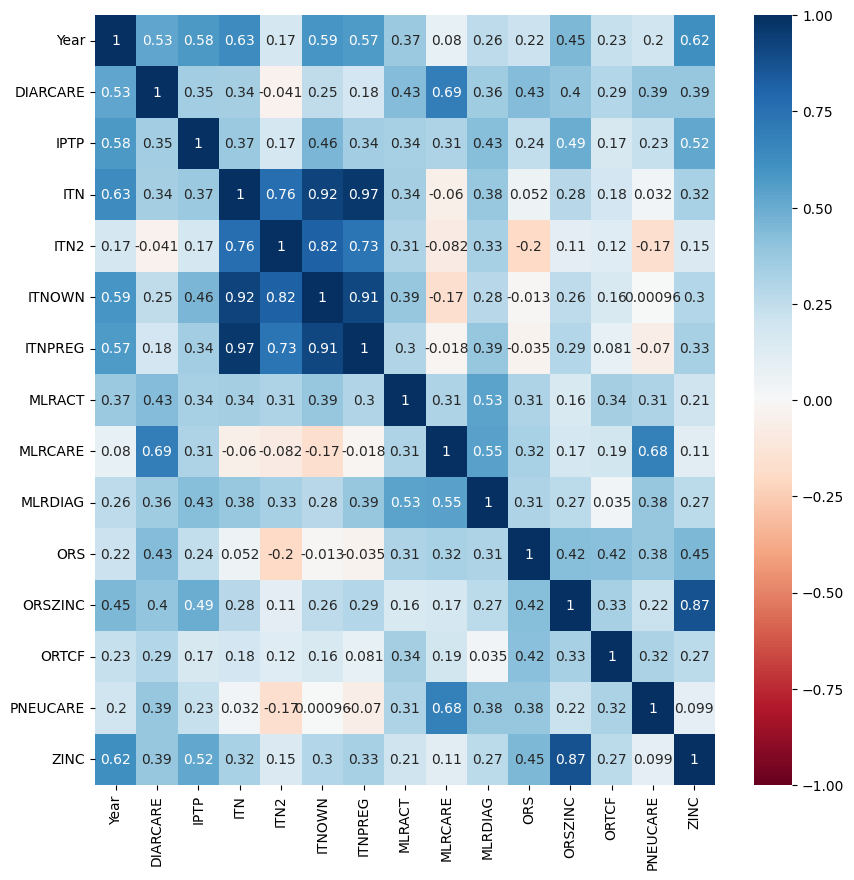

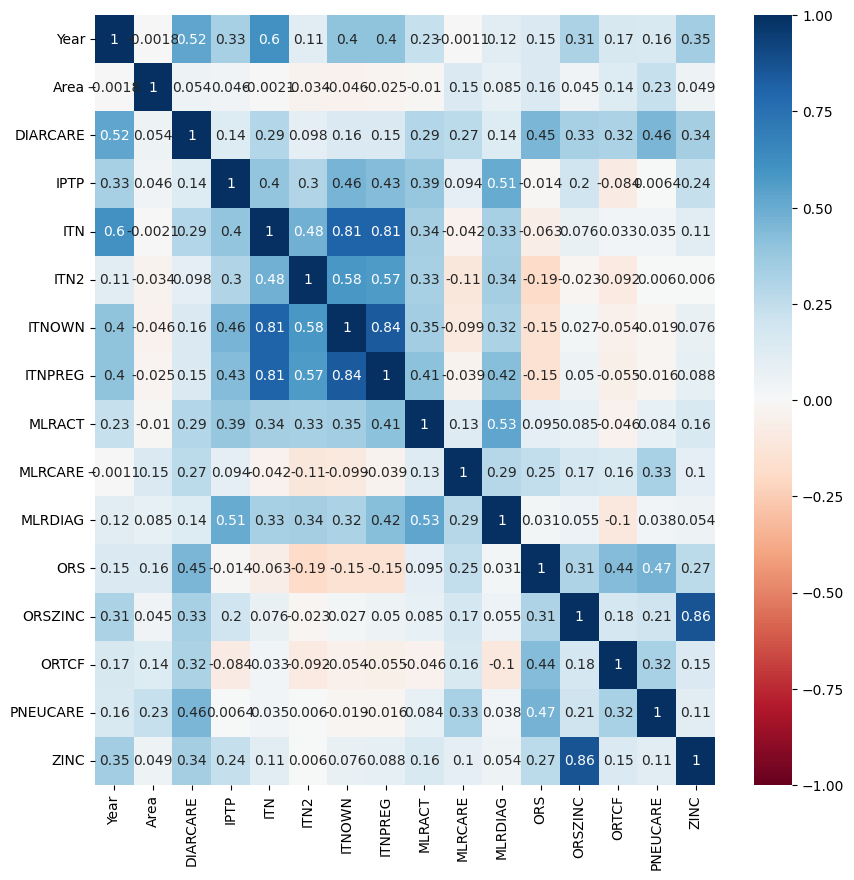

In [50]:
plt.figure(figsize=(10,10))
sns.heatmap(df0a.select_dtypes(exclude="object").corr(),  cmap="RdBu", vmin=-1, vmax=1, annot=True)

plt.figure(figsize=(10,10))
sns.heatmap(dt0.select_dtypes(exclude="object").corr(), cmap="RdBu", vmin=-1, vmax=1, annot=True)

## Model 1, 2, and 3

In [51]:
dt1 = dt0.select_dtypes(exclude="object").iloc[:,1:].copy()
dt1 = dt1[~dt1[var0].isna().any(axis=1)]

num_kol = dt1.columns.drop(var0)

In [52]:
dtX1 = dt1[num_kol]
dty1 = dt1[var0[0]]

dtX1tr, dtX1te, dty1tr, dty1te = train_test_split(dtX1, dty1, test_size = 0.2, random_state = 0)

# ordinal encoder
num_trf1 = Pipeline(steps=[("num_im", SimpleImputer(strategy="median"))])

# merge preprocessing
pre = ColumnTransformer(transformers=[
    ('num', num_trf1, num_kol)
])

In [53]:
# Define a list of regression models
models = [
    LinearRegression(),
    Ridge(random_state=42),
    Lasso(random_state=42),
    ElasticNet(random_state=42),
    DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42),
    XGBRegressor(random_state=42),
    LGBMRegressor(random_state=42),
]

res1 = pd.DataFrame()

for model in models:
    pipa = imbpipeline(steps=[
        ("pre", pre),
        ("clf", model)
    ])
    
    grid_search = GridSearchCV(estimator=pipa, param_grid = {}, cv=rkf, 
                               scoring={"RMSE":'neg_root_mean_squared_error',
                                        "MAE":'neg_mean_absolute_error',
                                        "EV":'explained_variance',
                                        "R2":'r2'},
                               verbose=1,
                               refit = "RMSE")
    
    grid_search.fit(dtX1tr, dty1tr)
    
    # Save the model's performance metrics in a dictionary
    
    pdf = pd.DataFrame(grid_search.cv_results_).filter(regex=("mean_test"))
    pdf["Model"] = type(model).__name__ 
    pdf.set_index("Model", inplace=True)
    
    # concat pdDF to the results list
    res1 = pd.concat([res1, pdf])
    
res1

Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits


,mean_test_RMSE,mean_test_MAE,mean_test_EV,mean_test_R2
Model,,,,
LinearRegression,-9.734271,-6.730556,0.219102,0.211702
Ridge,-9.733848,-6.729343,0.219168,0.211771
Lasso,-9.708497,-6.661108,0.223347,0.216105
ElasticNet,-9.714154,-6.669817,0.222288,0.215108
DecisionTreeRegressor,-12.078552,-7.496349,-0.218343,-0.227727
RandomForestRegressor,-8.856215,-5.728907,0.347343,0.345272
GradientBoostingRegressor,-9.194718,-6.116940,0.298496,0.296663
XGBRegressor,-9.337539,-6.142634,0.273913,0.272009
LGBMRegressor,-9.209074,-6.279736,0.294150,0.292510


In [54]:
dtX2 = dt1[num_kol]
dty2 = dt1[var0[1]]

dtX2tr, dtX2te, dty2tr, dty2te = train_test_split(dtX2, dty2, test_size = 0.2, random_state = 0)

# ordinal encoder
num_trf1 = Pipeline(steps=[("num_im", SimpleImputer(strategy="median"))])

# merge preprocessing
pre = ColumnTransformer(transformers=[
    ('num', num_trf1, num_kol)
])

In [55]:
# Define a list of regression models
models = [
    LinearRegression(),
    Ridge(random_state=42),
    Lasso(random_state=42),
    ElasticNet(random_state=42),
    DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42),
    XGBRegressor(random_state=42),
    LGBMRegressor(random_state=42),
]

res1 = pd.DataFrame()

for model in models:
    pipa = imbpipeline(steps=[
        ("pre", pre),
        ("clf", model)
    ])
    
    grid_search = GridSearchCV(estimator=pipa, param_grid = {}, cv=rkf, 
                               scoring={"RMSE":'neg_root_mean_squared_error',
                                        "MAE":'neg_mean_absolute_error',
                                        "EV":'explained_variance',
                                        "R2":'r2'},
                               verbose=1,
                               refit = "RMSE")
    
    grid_search.fit(dtX2tr, dty2tr)
    
    # Save the model's performance metrics in a dictionary
    
    pdf = pd.DataFrame(grid_search.cv_results_).filter(regex=("mean_test"))
    pdf["Model"] = type(model).__name__ 
    pdf.set_index("Model", inplace=True)
    
    # concat pdDF to the results list
    res1 = pd.concat([res1, pdf])
    
res1

Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits


,mean_test_RMSE,mean_test_MAE,mean_test_EV,mean_test_R2
Model,,,,
LinearRegression,-14.152855,-11.113366,0.249674,0.236309
Ridge,-14.152125,-11.111766,0.249760,0.236403
Lasso,-14.280008,-11.180511,0.235549,0.223161
ElasticNet,-14.272939,-11.170648,0.236529,0.223849
DecisionTreeRegressor,-17.851974,-13.093263,-0.211156,-0.221995
RandomForestRegressor,-12.936748,-9.823623,0.371925,0.362735
GradientBoostingRegressor,-13.224192,-10.082914,0.341909,0.334464
XGBRegressor,-13.929152,-10.542066,0.268328,0.258334
LGBMRegressor,-13.466438,-10.283660,0.320540,0.308863


In [56]:
dtX3 = dt1[num_kol]
dty3 = dt1[var0[2]]

dtX3tr, dtX3te, dty3tr, dty3te = train_test_split(dtX3, dty3, test_size = 0.2, random_state = 0)

# ordinal encoder
num_trf1 = Pipeline(steps=[("num_im", SimpleImputer(strategy="median"))])

# merge preprocessing
pre = ColumnTransformer(transformers=[
    ('num', num_trf1, num_kol)
])

In [57]:
# Define a list of regression models
models = [
    LinearRegression(),
    Ridge(random_state=42),
    Lasso(random_state=42),
    ElasticNet(random_state=42),
    DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42),
    XGBRegressor(random_state=42),
    LGBMRegressor(random_state=42),
]

res1 = pd.DataFrame()

for model in models:
    pipa = imbpipeline(steps=[
        ("pre", pre),
        ("clf", model)
    ])
    
    grid_search = GridSearchCV(estimator=pipa, param_grid = {}, cv=rkf, 
                               scoring={"RMSE":'neg_root_mean_squared_error',
                                        "MAE":'neg_mean_absolute_error',
                                        "EV":'explained_variance',
                                        "R2":'r2'},
                               verbose=1,
                               refit = "RMSE")
    
    grid_search.fit(dtX3tr, dty3tr)
    
    # Save the model's performance metrics in a dictionary
    
    pdf = pd.DataFrame(grid_search.cv_results_).filter(regex=("mean_test"))
    pdf["Model"] = type(model).__name__ 
    pdf.set_index("Model", inplace=True)
    
    # concat pdDF to the results list
    res1 = pd.concat([res1, pdf])
    
res1

Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits


,mean_test_RMSE,mean_test_MAE,mean_test_EV,mean_test_R2
Model,,,,
LinearRegression,-16.202101,-12.314114,0.361738,0.349678
Ridge,-16.200826,-12.313171,0.361833,0.349773
Lasso,-16.113174,-12.252496,0.368221,0.356370
ElasticNet,-16.128363,-12.261244,0.367124,0.355177
DecisionTreeRegressor,-18.834163,-12.793290,0.121042,0.118545
RandomForestRegressor,-13.433399,-9.988367,0.555312,0.551987
GradientBoostingRegressor,-13.832927,-10.321947,0.529212,0.525156
XGBRegressor,-14.045093,-10.206656,0.513409,0.509924
LGBMRegressor,-14.001328,-10.381926,0.516770,0.512169


### ALL YEAH

In [58]:
def moData(model, data, pre="preprocess", clf="clf"):
    pre = model.best_estimator_.named_steps[pre]
    data = pre.transform(data)
    fitur = [j.split("__")[1] for j in pre.get_feature_names_out()]
    mod = model.best_estimator_.named_steps[clf]
    dat = pd.DataFrame(data, columns=fitur)
    return mod, dat

def idShap(model, data, pre="preprocess", clf="clf", en = 1):
    mod, dat = moData(model, data)
    
    # individual
    datn = dat.iloc[(en-1):en,:]
    explainer = shap.TreeExplainer(mod, approximate=True)
    shap_values = explainer.shap_values(datn)
    return shap.force_plot(explainer.expected_value, shap_values, datn, matplotlib=True, show=False, contribution_threshold=0.05)

def id_shap1(model, data, pre="preprocess", clf="clf", which="all"):
    mod, dat = moData(model, data)
    shapval = shap.TreeExplainer(mod, approximate=True).shap_values(dat)
    return shapval, dat

def pl_shap1(val, data):
#     shap.summary_plot(val, data)
    shap.summary_plot(val, data, plot_type="violin", color='coolwarm')
    plt.tight_layout()

def pl_shap2(val, data, kolom="all", R=8, K=4):
    if kolom == "all": 
        kolom = data.columns
    
    fig, axes = plt.subplots(R, K, figsize=(20,16))
    axes = axes.ravel()
    display(axes)
    
    for i, var in enumerate(kolom):
        shap.dependence_plot(var, val, data, ax=axes[i], show=False)   
    plt.tight_layout()
    


### Model 1: RF**

In [59]:
rf1 = imbpipeline(steps=[
    ("preprocess", pre),
    ("clf", RandomForestRegressor(random_state=0))
])

param_grid = {
#     'clf__learning_rate': [0.1, 0.05, 0.2],
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [3, 7, 10, None],
#     'clf__subsample': [0.6, 0.7, 0.8],
#     'clf__reg_alpha': [0.1, 0.2, 0.3, 0.4, 0.5],
#     'clf__reg_lambda': [0.1, 0.2, 0.3, 0.4, 0.5]
}



grid_rf1 = GridSearchCV(estimator=rf1, param_grid=param_grid, cv=rkf, 
                        scoring={"RMSE":'neg_root_mean_squared_error',
                                 "MAE":'neg_mean_absolute_error',
                                 "EV":'explained_variance',
                                 "R2":'r2'}, 
                         verbose = 1, refit="RMSE")

# Melakukan tuning hyperparameter
grid_rf1.fit(dtX1tr, dty1tr)

# Mendapatkan model terbaik
print("Best Parameter", grid_rf1.best_params_)

Fitting 6 folds for each of 12 candidates, totalling 72 fits
Best Parameter {'clf__max_depth': None, 'clf__n_estimators': 200}


In [60]:
display(grid_rf1.best_estimator_.get_params()["clf"].get_params())
display(pd.DataFrame(grid_rf1.cv_results_).filter(regex='^mean',axis=1))

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

,mean_fit_time,mean_score_time,mean_test_RMSE,mean_test_MAE,mean_test_EV,mean_test_R2
0,0.184559,0.008503,-9.649367,-6.463125,0.229687,0.225266
1,0.354857,0.012353,-9.638983,-6.464947,0.231531,0.227143
2,0.534424,0.015646,-9.638015,-6.460842,0.231599,0.227248
3,0.259677,0.009491,-8.985783,-5.936637,0.329964,0.327476
4,0.553722,0.015560,-8.970286,-5.911569,0.332256,0.329888
5,0.732424,0.017669,-8.972726,-5.913821,0.331936,0.329561
6,0.292722,0.010129,-8.870352,-5.778828,0.345824,0.343538
7,0.567700,0.014966,-8.842509,-5.735164,0.350305,0.348177
8,0.843230,0.019367,-8.847710,-5.733901,0.349430,0.347364
9,0.312071,0.011026,-8.812322,-5.708842,0.354629,0.352292


In [61]:
var0

['MLRCARE', 'PNEUCARE', 'DIARCARE']

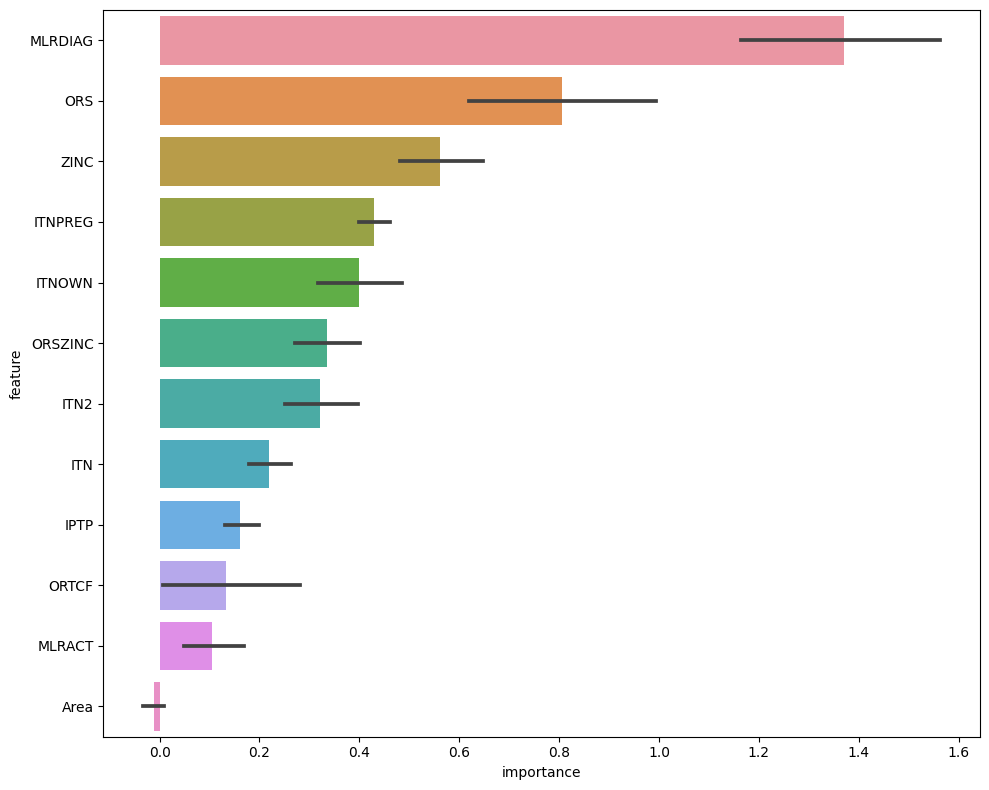

In [62]:
perm1 = permutation_importance(grid_rf1, dtX1te, dty1te, n_repeats=10, random_state=0, n_jobs=-1)
perm1 = pd.DataFrame({'feature': dtX1te.columns.tolist()*10, 
                     'importance': perm1["importances"].transpose().reshape(-1)})

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=perm1, 
            order=perm1.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.tight_layout()


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


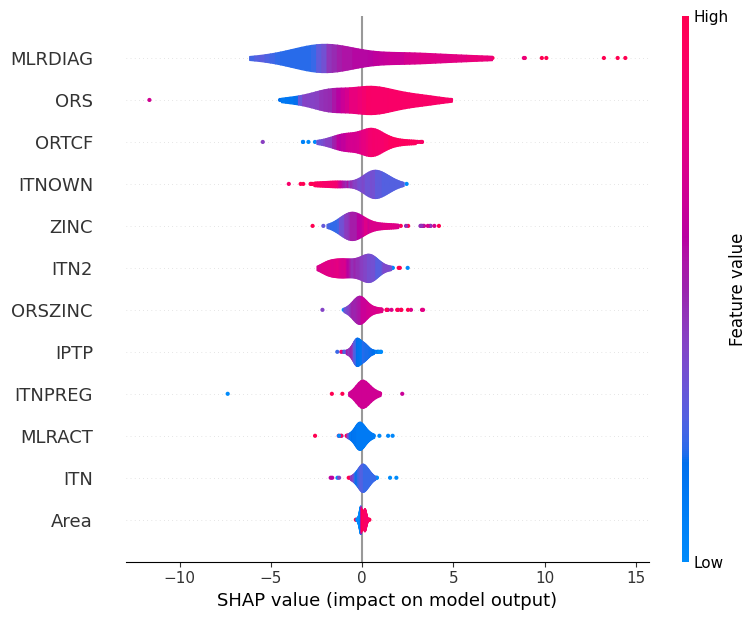

<Figure size 640x480 with 0 Axes>

In [63]:
valx1, datx1 = id_shap1(grid_rf1, dtX2te)
pl_shap1(valx1, datx1)

### Model 2: RF

In [64]:
rf2 = imbpipeline(steps=[
    ("preprocess", pre),
    ("clf", RandomForestRegressor(random_state=0))
])

param_grid = {
#     'clf__learning_rate': [0.1, 0.05, 0.2],
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [3, 7, 10, None],
#     'clf__subsample': [0.6, 0.7, 0.8],
#     'clf__reg_alpha': [0.1, 0.2, 0.3, 0.4, 0.5],
#     'clf__reg_lambda': [0.1, 0.2, 0.3, 0.4, 0.5]
}



grid_rf2 = GridSearchCV(estimator=rf2, param_grid=param_grid, cv=rkf, 
                        scoring={"RMSE":'neg_root_mean_squared_error',
                                 "MAE":'neg_mean_absolute_error',
                                 "EV":'explained_variance',
                                 "R2":'r2'}, 
                         verbose = 1, refit="RMSE")

# Melakukan tuning hyperparameter
grid_rf2.fit(dtX2tr, dty2tr)

# Mendapatkan model terbaik
print("Best Parameter", grid_rf2.best_params_)

Fitting 6 folds for each of 12 candidates, totalling 72 fits
Best Parameter {'clf__max_depth': None, 'clf__n_estimators': 300}


In [65]:
display(grid_rf2.best_estimator_.get_params()["clf"].get_params())
display(pd.DataFrame(grid_rf2.cv_results_).filter(regex='^mean',axis=1))


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

,mean_fit_time,mean_score_time,mean_test_RMSE,mean_test_MAE,mean_test_EV,mean_test_R2
0,0.189685,0.008582,-13.438388,-10.545865,0.320878,0.313021
1,0.358999,0.012260,-13.416322,-10.514963,0.323274,0.315304
2,0.538817,0.015480,-13.418283,-10.514213,0.323121,0.315078
3,0.255815,0.009423,-13.072972,-10.057510,0.357885,0.349674
4,0.509425,0.014104,-13.017296,-10.027788,0.363121,0.355192
5,0.751793,0.018000,-13.008470,-10.030349,0.364054,0.356107
6,0.297534,0.010088,-12.993233,-9.914109,0.365004,0.357078
7,0.584487,0.015455,-12.971715,-9.922468,0.367639,0.359316
8,0.881135,0.020362,-12.953604,-9.916584,0.369531,0.361240
9,0.317175,0.010579,-12.958258,-9.867879,0.368828,0.360418


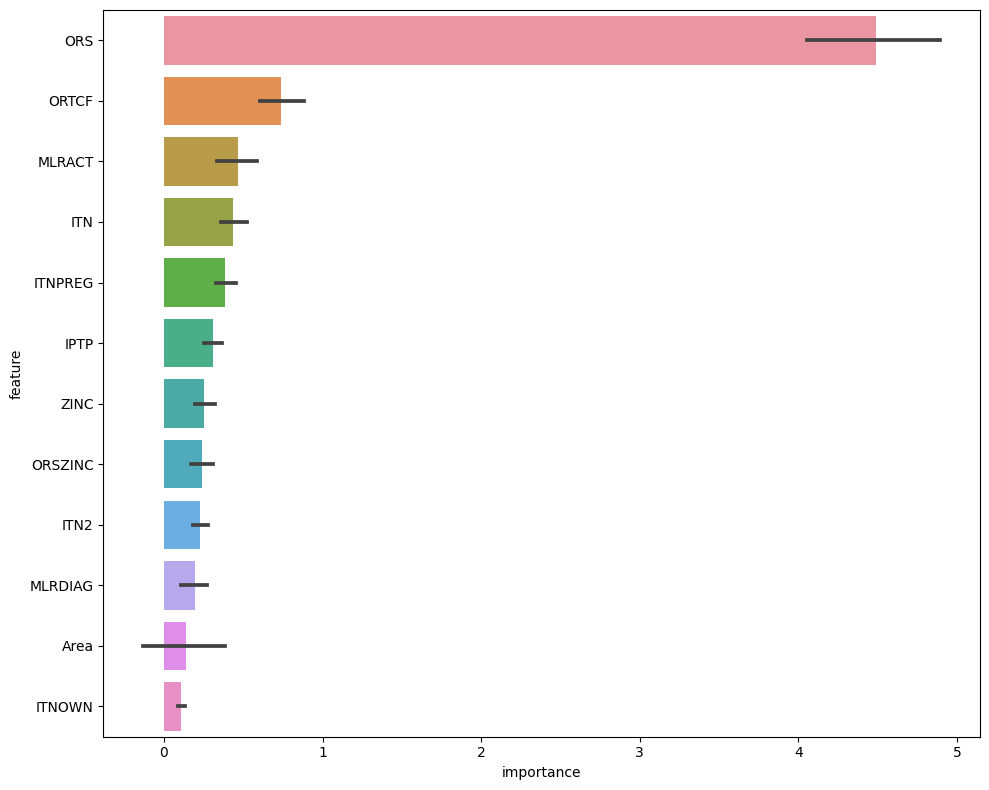

In [66]:
perm2 = permutation_importance(grid_rf2, dtX2te, dty2te, n_repeats=10, random_state=0, n_jobs=-1)
perm2 = pd.DataFrame({'feature': dtX2te.columns.tolist()*10, 
                     'importance': perm2["importances"].transpose().reshape(-1)})

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=perm2, 
            order=perm2.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.tight_layout()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


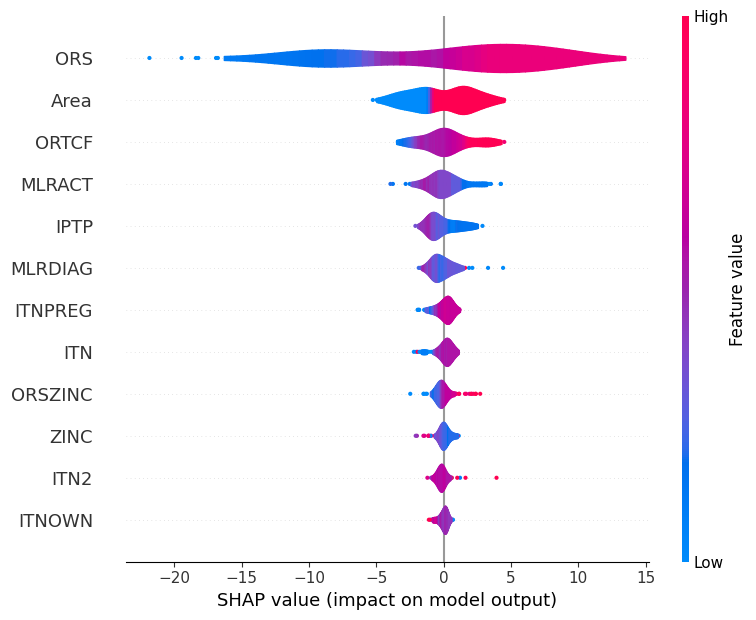

<Figure size 640x480 with 0 Axes>

In [67]:
valx2, datx2 = id_shap1(grid_rf2, dtX2te)
pl_shap1(valx2, datx2)

### Model 3: LGBM

In [68]:
lg3 = imbpipeline(steps=[
    ("preprocess", pre),
    ("clf", LGBMRegressor(random_state=0))
])

param_grid = {
#     'clf__learning_rate': [0.1, 0.05, 0.2],
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [3, 7, 10, None],
#     'clf__subsample': [0.6, 0.7, 0.8],
#     'clf__reg_alpha': [0.1, 0.2, 0.3, 0.4, 0.5],
#     'clf__reg_lambda': [0.1, 0.2, 0.3, 0.4, 0.5]
}


grid_lg3 = GridSearchCV(estimator=lg3, param_grid=param_grid, cv=rkf, 
                        scoring={"RMSE":'neg_root_mean_squared_error',
                                 "MAE":'neg_mean_absolute_error',
                                 "EV":'explained_variance',
                                 "R2":'r2'}, 
                         verbose = 1, refit="RMSE")

# Melakukan tuning hyperparameter
grid_lg3.fit(dtX3tr, dty3tr)

# Mendapatkan model terbaik
print("Best Parameter", grid_lg3.best_params_)

Fitting 6 folds for each of 12 candidates, totalling 72 fits
Best Parameter {'clf__max_depth': None, 'clf__n_estimators': 300}


In [69]:
display(grid_lg3.best_estimator_.get_params()["clf"].get_params())
display(pd.DataFrame(grid_lg3.cv_results_).filter(regex='^mean',axis=1))


{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': None,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 0,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

,mean_fit_time,mean_score_time,mean_test_RMSE,mean_test_MAE,mean_test_EV,mean_test_R2
0,0.161797,0.005845,-13.974519,-10.511026,0.519644,0.515688
1,0.285177,0.006357,-13.881195,-10.327290,0.525409,0.521666
2,0.506326,0.006558,-13.848629,-10.217106,0.527064,0.523699
3,0.492889,0.007459,-14.016448,-10.387554,0.515879,0.511685
4,0.608918,0.006620,-13.887147,-10.196339,0.523666,0.520045
5,0.952677,0.006934,-13.862699,-10.155028,0.525516,0.521683
6,0.359277,0.006101,-13.968042,-10.338439,0.519523,0.514805
7,0.673131,0.006661,-13.842277,-10.178266,0.526899,0.522658
8,1.034357,0.007021,-13.834976,-10.143334,0.527489,0.523128
9,0.365910,0.005899,-14.001328,-10.381926,0.516770,0.512169


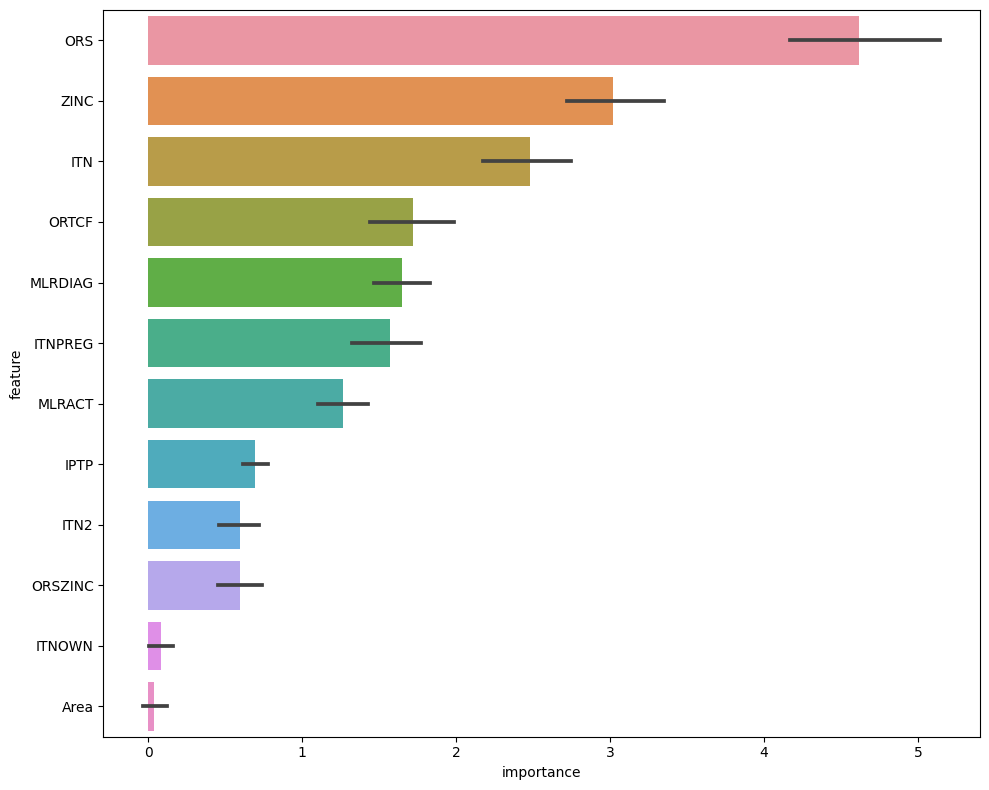

In [70]:
perm3 = permutation_importance(grid_lg3, dtX3te, dty3te, n_repeats=10, random_state=0, n_jobs=-1)
perm3 = pd.DataFrame({'feature': dtX3te.columns.tolist()*10, 
                     'importance': perm3["importances"].transpose().reshape(-1)})

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=perm3, 
            order=perm3.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.tight_layout()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


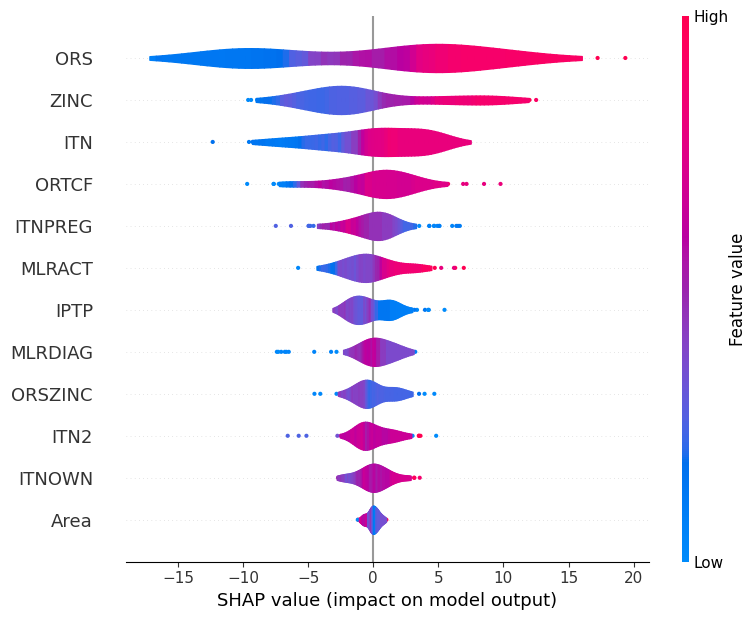

<Figure size 640x480 with 0 Axes>

In [71]:
valx3, datx3 = id_shap1(grid_lg3, dtX3te)
pl_shap1(valx3, datx3)